# With the new control and armflapping videos (shorter directories), let's see whether we can get a higher accuracy. 

In [1]:
import cv2, os 
import numpy as np 
import warnings 
warnings.filterwarnings("ignore")

## create a function to detect all landmarks in a given frame 

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp


def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1; 
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [3]:
# time to actually do calibration. 

SECONDS_TO_DETECT = 2 # in seconds
DISTANCE_BETWEEN_INPUTS = 0.01 # in seconds, only matters if sampling is True
sampling = False 

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

armflapping_videos:  18%|█▊        | 19/108 [00:00<00:02, 30.76it/s]

failed on .DS_Store


control_videos:  23%|██▎       | 14/62 [00:00<00:03, 15.42it/s]

failed on .DS_Store


control_videos: 100%|██████████| 62/62 [00:03<00:00, 19.67it/s]


(97, 50)

In [4]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


In [8]:
print([len(video) for video in ARMFLAPPING_LOCATIONS])
print([len(video) for video in CONTROL_LOCATIONS])

[121, 61, 121, 90, 90, 90, 72, 90, 90, 49, 49, 90, 90, 90, 72, 90, 121, 49, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 121, 90, 90, 90, 90, 91, 90, 120, 90, 90, 121, 91, 90, 90, 90, 90, 45, 45, 121, 90, 90]
[121, 121, 90, 90, 72, 72, 90, 91, 49, 49, 49, 61, 45, 72, 72, 72, 73, 90, 60, 121, 90, 49, 90, 90, 73, 90, 73, 49, 121, 90, 90, 90, 60, 90, 121, 90, 41, 121, 45, 60, 121, 90, 90, 121, 90, 61, 46, 45, 45, 121]


In [5]:
# to balance classes 
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

## after balancing the classes, pad the data and convert to numpy arrays 

In [13]:
# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = np.array(locations).tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

NameError: name 'ARMFLAPPING_LOCATIONS' is not defined

In [13]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

## function below to plot the model accuracy + loss through training. 

In [3]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array([test_frames])
    test_frames = pad(test_frames, maxlen = 90)
    
    return model.predict(test_frames)

## create the augmenter() class to do shift augmentations

In [4]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] 
        Y_locations = X[:, 42:84] 
        Z_locations = X[:, 84:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:, 42:84] + mask * tf.ones_like(X[:, 42:84]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:, 42:84] - mask * tf.ones_like(X[:, 42:84]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:, :42] + mask * tf.ones_like(X[:, :42]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:, :42] - mask * tf.ones_like(X[:, :42]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:, 84:] + mask * tf.ones_like(X[:, 84:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:, 84:] - mask * tf.ones_like(X[:, 84:]) * move_close)

        return X



class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X):
        return tf.map_fn(_shift, X)
        
        

In [48]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('all_points_folds'): 
    with open(f"all_points_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [49]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[:, column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = (1, 0)) 
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [50]:
X = interp_X(X)

(100, 90, 126)


## functions to plot the ROC and AURROC bar graph for each fold in a run, and for each run

In [7]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

## k-fold cross validation shown below

In [8]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [51]:
import random 
def shuffle(X, y, seed = None):
    if not seed:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 126)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y, seed=65)

In [52]:
import tensorflow as tf 
def make_model(): 
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=False), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model 

## run 10 times to gather results!

Epoch 1/75
3/3 [==============================] - 1s 266ms/step - loss: 0.6955 - accuracy: 0.6125 - precision_69: 0.6341 - recall_69: 0.6190 - val_loss: 0.7043 - val_accuracy: 0.5500 - val_precision_69: 0.4000 - val_recall_69: 0.2500
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6856 - accuracy: 0.6125 - precision_69: 0.6486 - recall_69: 0.5714 - val_loss: 0.6935 - val_accuracy: 0.7000 - val_precision_69: 0.6250 - val_recall_69: 0.6250
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6737 - accuracy: 0.6625 - precision_69: 0.6531 - recall_69: 0.7619 - val_loss: 0.6830 - val_accuracy: 0.7000 - val_precision_69: 0.6250 - val_recall_69: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6663 - accuracy: 0.6875 - precision_69: 0.6545 - recall_69: 0.8571 - val_loss: 0.6728 - val_accuracy: 0.7000 - val_precision_69: 0.6250 - val_recall_69: 0.6250
Epoch 5/75
3/3 [==============================] - 0s 138ms/step 

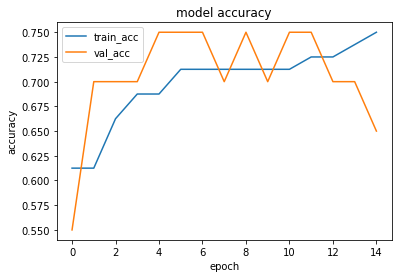

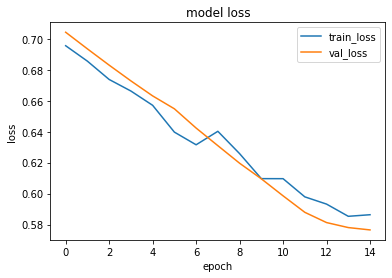

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.5864037]]


1it [00:00, 12671.61it/s]


prediction for video armflapping_3.mov is [[0.51238686]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_2.mov is [[0.58764666]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.39936963]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.6188929]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.50733864]]
Epoch 1/75
3/3 [==============================] - 1s 238ms/step - loss: 0.7190 - accuracy: 0.3375 - precision_70: 0.2143 - recall_70: 0.1622 - val_loss: 0.7119 - val_accuracy: 0.4000 - val_precision_70: 0.5556 - val_recall_70: 0.3846
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6974 - accuracy: 0.3375 - precision_70: 0.2895 - recall_70: 0.2973 - val_loss: 0.6864 - val_accuracy: 0.6500 - val_precision_70: 0.8750 - val_recall_70: 0.5385
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6918 - accuracy: 0.5375 - precision_70: 0.5000 - recall_70: 0.5405 - val_loss: 0.6627 - val_accuracy: 0.6500 - val_precision_70: 0.7500 - val_recall_70: 0.6923
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6791 - accuracy: 0.6000 - precision_70: 0.5532 - recall_70: 0.7027 - val_loss: 0.6459 - val_accuracy: 0.7500 - val_precision_70: 0.7857 - val_recall_70: 0.8462
Epoch 5/75


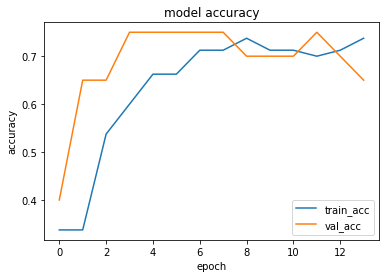

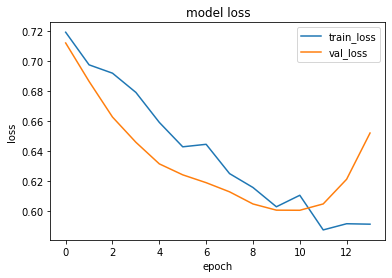

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.2132195]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_3.mov is [[0.5435322]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.16380018]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.131428]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.77175677]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.1251103]]
Epoch 1/75
3/3 [==============================] - 1s 236ms/step - loss: 0.6702 - accuracy: 0.6500 - precision_71: 0.5932 - recall_71: 0.8974 - val_loss: 0.6624 - val_accuracy: 0.6500 - val_precision_71: 0.6250 - val_recall_71: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6433 - accuracy: 0.7375 - precision_71: 0.6957 - recall_71: 0.8205 - val_loss: 0.6559 - val_accuracy: 0.6000 - val_precision_71: 0.6000 - val_recall_71: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6450 - accuracy: 0.7250 - precision_71: 0.6735 - recall_71: 0.8462 - val_loss: 0.6497 - val_accuracy: 0.6500 - val_precision_71: 0.6250 - val_recall_71: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6491 - accuracy: 0.7125 - precision_71: 0.6667 - recall_71: 0.8205 - val_loss: 0.6439 - val_accuracy: 0.6000 - val_precision_71: 0.6000 - val_recall_71: 0.8182
Epoch 5/75
3

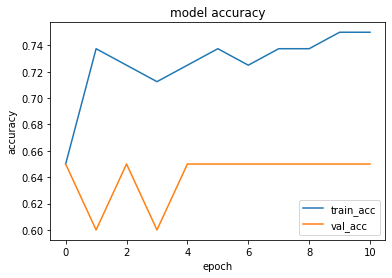

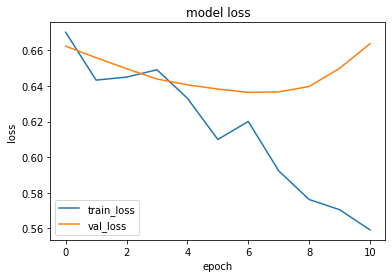

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.24305806]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.61393166]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.16664365]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.07448208]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.84264386]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.15256983]]
Epoch 1/75
3/3 [==============================] - 1s 232ms/step - loss: 0.7021 - accuracy: 0.4375 - precision_72: 0.3529 - recall_72: 0.1500 - val_loss: 0.6869 - val_accuracy: 0.6500 - val_precision_72: 0.6000 - val_recall_72: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6780 - accuracy: 0.6250 - precision_72: 0.6000 - recall_72: 0.7500 - val_loss: 0.6688 - val_accuracy: 0.6000 - val_precision_72: 0.5556 - val_recall_72: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6657 - accuracy: 0.5875 - precision_72: 0.5507 - recall_72: 0.9500 - val_loss: 0.6526 - val_accuracy: 0.6000 - val_precision_72: 0.5556 - val_recall_72: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6564 - accuracy: 0.6250 - precision_72: 0.5806 - recall_72: 0.9000 - val_loss: 0.6383 - val_accuracy: 0.6500 - val_precision_72: 0.6000 - val_recall_72: 0.9000
Epoch 5/75


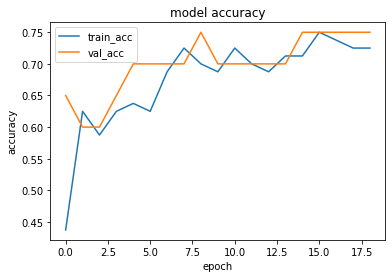

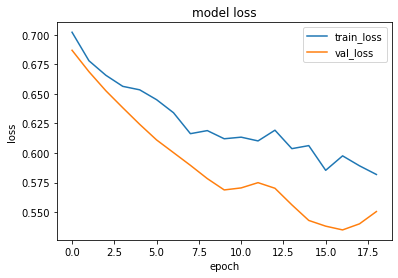

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.5493528]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.54823864]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.41779318]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.13751674]]


1it [00:00, 12336.19it/s]


prediction for video control_2.mov is [[0.7977009]]


1it [00:00, 12865.96it/s]


prediction for video control_3.mov is [[0.4180866]]
Epoch 1/75
3/3 [==============================] - 1s 239ms/step - loss: 0.6993 - accuracy: 0.6000 - precision_73: 0.6087 - recall_73: 0.6667 - val_loss: 0.6766 - val_accuracy: 0.7000 - val_precision_73: 0.5833 - val_recall_73: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6583 - accuracy: 0.7250 - precision_73: 0.7083 - recall_73: 0.8095 - val_loss: 0.6800 - val_accuracy: 0.6500 - val_precision_73: 0.5385 - val_recall_73: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6513 - accuracy: 0.6500 - precision_73: 0.6167 - recall_73: 0.8810 - val_loss: 0.6859 - val_accuracy: 0.4000 - val_precision_73: 0.3889 - val_recall_73: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6235 - accuracy: 0.6125 - precision_73: 0.5873 - recall_73: 0.8810 - val_loss: 0.6928 - val_accuracy: 0.5500 - val_precision_73: 0.4667 - val_recall_73: 0.8750
Epoch 5/75
3

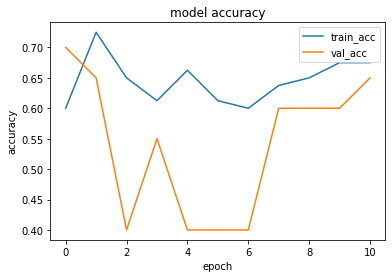

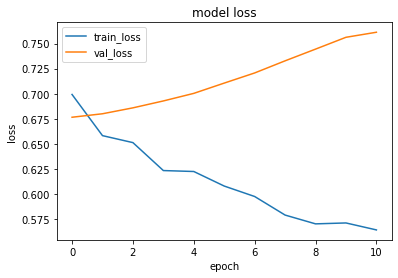

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.38447234]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.6118508]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.17683783]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.07817835]]


1it [00:00, 13662.23it/s]


prediction for video control_2.mov is [[0.8823437]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.15170348]]


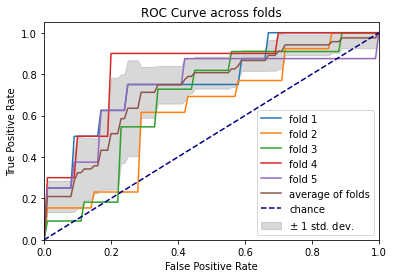

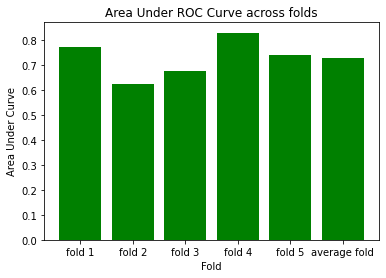

In [53]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.6979 - accuracy: 0.4125 - precision_75: 0.4390 - recall_75: 0.4286 - val_loss: 0.6818 - val_accuracy: 0.5500 - val_precision_75: 0.4706 - val_recall_75: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6748 - accuracy: 0.5625 - precision_75: 0.5507 - recall_75: 0.9048 - val_loss: 0.6703 - val_accuracy: 0.5000 - val_precision_75: 0.4444 - val_recall_75: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 125ms/step - loss: 0.6494 - accuracy: 0.5750 - precision_75: 0.5541 - recall_75: 0.9762 - val_loss: 0.6622 - val_accuracy: 0.5000 - val_precision_75: 0.4444 - val_recall_75: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6505 - accuracy: 0.5500 - precision_75: 0.5395 - recall_75: 0.9762 - val_loss: 0.6461 - val_accuracy: 0.5000 - val_precision_75: 0.4444 - val_recall_75: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 137ms/step 

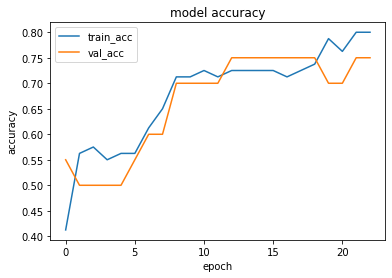

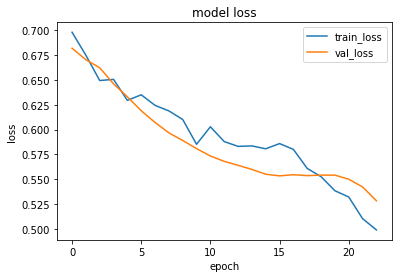

1it [00:00, 17331.83it/s]


prediction for video armflapping_1.mov is [[0.31007218]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.5826496]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.19851547]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.11861023]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.7798688]]


1it [00:00, 14027.77it/s]


prediction for video control_3.mov is [[0.17313793]]
Epoch 1/75
3/3 [==============================] - 1s 206ms/step - loss: 0.7008 - accuracy: 0.5250 - precision_76: 0.4839 - recall_76: 0.4054 - val_loss: 0.6813 - val_accuracy: 0.7000 - val_precision_76: 0.8182 - val_recall_76: 0.6923
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6973 - accuracy: 0.5875 - precision_76: 0.5625 - recall_76: 0.4865 - val_loss: 0.6630 - val_accuracy: 0.7500 - val_precision_76: 0.7857 - val_recall_76: 0.8462
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6659 - accuracy: 0.7000 - precision_76: 0.6444 - recall_76: 0.7838 - val_loss: 0.6492 - val_accuracy: 0.7500 - val_precision_76: 0.7857 - val_recall_76: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6535 - accuracy: 0.7250 - precision_76: 0.6667 - recall_76: 0.8108 - val_loss: 0.6361 - val_accuracy: 0.7500 - val_precision_76: 0.7857 - val_recall_76: 0.8462
Epoch 5/75


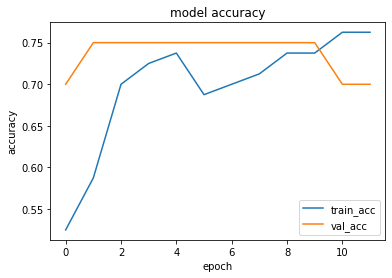

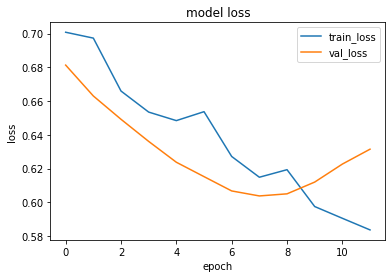

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.14832431]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.56103593]]


1it [00:00, 9892.23it/s]


prediction for video armflapping_2.mov is [[0.11791891]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.09485349]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.8365953]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.10701323]]
Epoch 1/75
3/3 [==============================] - 1s 210ms/step - loss: 0.6918 - accuracy: 0.5625 - precision_77: 0.5526 - recall_77: 0.5385 - val_loss: 0.6817 - val_accuracy: 0.6500 - val_precision_77: 0.7000 - val_recall_77: 0.6364
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6837 - accuracy: 0.6500 - precision_77: 0.6667 - recall_77: 0.5641 - val_loss: 0.6706 - val_accuracy: 0.6500 - val_precision_77: 0.6429 - val_recall_77: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6698 - accuracy: 0.7125 - precision_77: 0.6739 - recall_77: 0.7949 - val_loss: 0.6613 - val_accuracy: 0.6500 - val_precision_77: 0.6429 - val_recall_77: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6593 - accuracy: 0.7375 - precision_77: 0.6957 - recall_77: 0.8205 - val_loss: 0.6543 - val_accuracy: 0.6500 - val_precision_77: 0.6429 - val_recall_77: 0.8182
Epoch 5/75


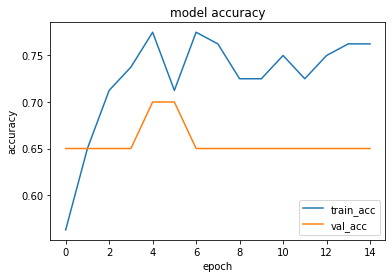

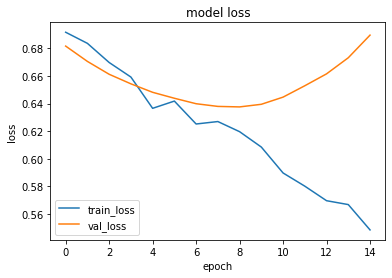

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.16721946]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_3.mov is [[0.60256755]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.1355561]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.07920355]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.85318226]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.10431239]]
Epoch 1/75
3/3 [==============================] - 1s 196ms/step - loss: 0.7039 - accuracy: 0.5125 - precision_78: 0.5294 - recall_78: 0.2250 - val_loss: 0.6834 - val_accuracy: 0.7000 - val_precision_78: 0.7500 - val_recall_78: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6937 - accuracy: 0.5125 - precision_78: 0.5128 - recall_78: 0.5000 - val_loss: 0.6658 - val_accuracy: 0.6500 - val_precision_78: 0.5882 - val_recall_78: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6675 - accuracy: 0.5750 - precision_78: 0.5484 - recall_78: 0.8500 - val_loss: 0.6524 - val_accuracy: 0.6000 - val_precision_78: 0.5556 - val_recall_78: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6677 - accuracy: 0.5875 - precision_78: 0.5556 - recall_78: 0.8750 - val_loss: 0.6417 - val_accuracy: 0.6000 - val_precision_78: 0.5556 - val_recall_78: 1.0000
Epoch 5/75


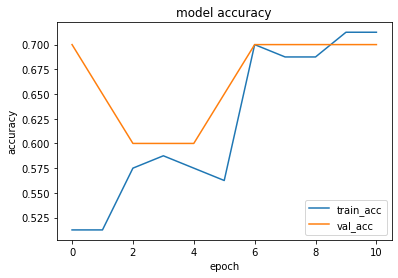

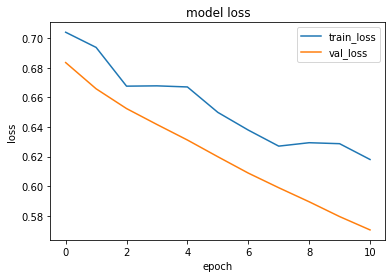

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.4083464]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.555054]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.29556054]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.17543525]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.75078154]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.21018869]]
Epoch 1/75
3/3 [==============================] - 1s 198ms/step - loss: 0.7111 - accuracy: 0.4375 - precision_79: 0.4444 - recall_79: 0.2857 - val_loss: 0.7044 - val_accuracy: 0.1500 - val_precision_79: 0.1538 - val_recall_79: 0.2500
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6809 - accuracy: 0.4625 - precision_79: 0.4909 - recall_79: 0.6429 - val_loss: 0.7028 - val_accuracy: 0.4000 - val_precision_79: 0.3889 - val_recall_79: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6616 - accuracy: 0.5625 - precision_79: 0.5493 - recall_79: 0.9286 - val_loss: 0.7039 - val_accuracy: 0.3500 - val_precision_79: 0.3684 - val_recall_79: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6546 - accuracy: 0.5875 - precision_79: 0.5634 - recall_79: 0.9524 - val_loss: 0.7073 - val_accuracy: 0.3500 - val_precision_79: 0.3684 - val_recall_79: 0.8750
Epoch 5/75


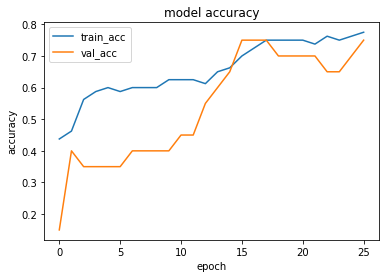

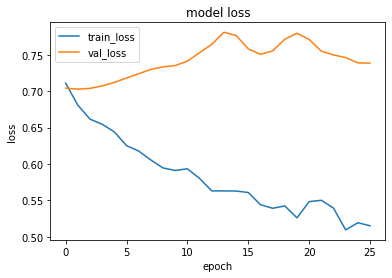

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.6928163]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.6016967]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.29945272]]


1it [00:00, 10866.07it/s]


prediction for video control_1.mov is [[0.03973913]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.8827543]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.18187937]]


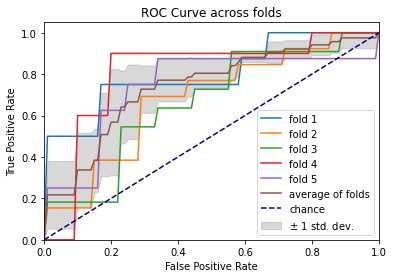

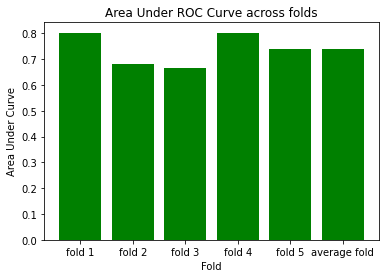

In [54]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 333ms/step - loss: 0.7121 - accuracy: 0.4625 - precision_81: 0.4857 - recall_81: 0.4048 - val_loss: 0.6951 - val_accuracy: 0.4000 - val_precision_81: 0.4000 - val_recall_81: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6860 - accuracy: 0.5375 - precision_81: 0.5342 - recall_81: 0.9286 - val_loss: 0.6743 - val_accuracy: 0.5500 - val_precision_81: 0.4706 - val_recall_81: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6759 - accuracy: 0.5375 - precision_81: 0.5352 - recall_81: 0.9048 - val_loss: 0.6599 - val_accuracy: 0.5500 - val_precision_81: 0.4706 - val_recall_81: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6545 - accuracy: 0.5875 - precision_81: 0.5652 - recall_81: 0.9286 - val_loss: 0.6478 - val_accuracy: 0.5500 - val_precision_81: 0.4706 - val_recall_81: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 135ms/step 

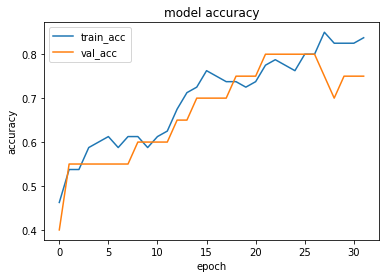

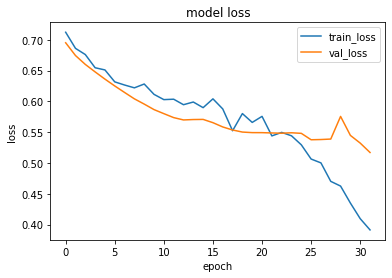

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4940407]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.5358076]]


1it [00:00, 12052.60it/s]


prediction for video armflapping_2.mov is [[0.26889825]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.1065301]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.80931437]]


1it [00:00, 10330.80it/s]


prediction for video control_3.mov is [[0.31895447]]
Epoch 1/75
3/3 [==============================] - 1s 228ms/step - loss: 0.6909 - accuracy: 0.5625 - precision_82: 0.5152 - recall_82: 0.9189 - val_loss: 0.6552 - val_accuracy: 0.7000 - val_precision_82: 0.7333 - val_recall_82: 0.8462
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6764 - accuracy: 0.7250 - precision_82: 0.6667 - recall_82: 0.8108 - val_loss: 0.6564 - val_accuracy: 0.7000 - val_precision_82: 0.8182 - val_recall_82: 0.6923
Epoch 3/75
3/3 [==============================] - 1s 207ms/step - loss: 0.6589 - accuracy: 0.7250 - precision_82: 0.7273 - recall_82: 0.6486 - val_loss: 0.6541 - val_accuracy: 0.6500 - val_precision_82: 0.8750 - val_recall_82: 0.5385
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6408 - accuracy: 0.7125 - precision_82: 0.7500 - recall_82: 0.5676 - val_loss: 0.6511 - val_accuracy: 0.6000 - val_precision_82: 0.8571 - val_recall_82: 0.4615
Epoch 5/75


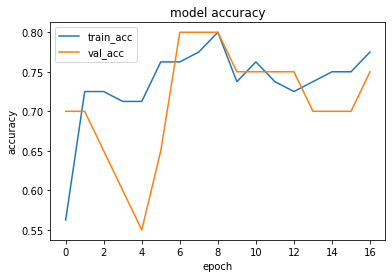

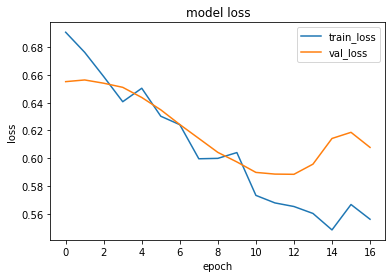

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.28635424]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.5102301]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.1881671]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.09869033]]


1it [00:00, 16320.25it/s]


prediction for video control_2.mov is [[0.83080804]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.2199556]]
Epoch 1/75
3/3 [==============================] - 1s 199ms/step - loss: 0.7312 - accuracy: 0.4125 - precision_83: 0.3333 - recall_83: 0.2051 - val_loss: 0.7144 - val_accuracy: 0.4000 - val_precision_83: 0.4444 - val_recall_83: 0.3636
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7063 - accuracy: 0.5000 - precision_83: 0.4865 - recall_83: 0.4615 - val_loss: 0.6931 - val_accuracy: 0.6500 - val_precision_83: 0.6429 - val_recall_83: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6773 - accuracy: 0.5875 - precision_83: 0.5652 - recall_83: 0.6667 - val_loss: 0.6765 - val_accuracy: 0.7000 - val_precision_83: 0.6667 - val_recall_83: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6604 - accuracy: 0.6500 - precision_83: 0.6000 - recall_83: 0.8462 - val_loss: 0.6641 - val_accuracy: 0.6500 - val_precision_83: 0.6250 - val_recall_83: 0.9091
Epoch 5/75
3

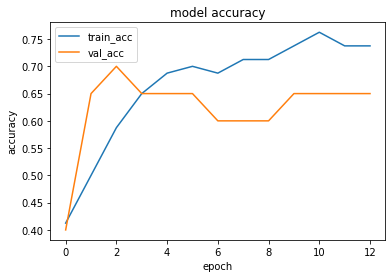

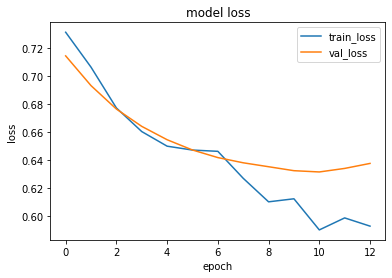

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.27594227]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.61137474]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.23309964]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.11905044]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.8010599]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.1486209]]
Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.7046 - accuracy: 0.6375 - precision_84: 0.6000 - recall_84: 0.8250 - val_loss: 0.6711 - val_accuracy: 0.6500 - val_precision_84: 0.6000 - val_recall_84: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6929 - accuracy: 0.6875 - precision_84: 0.6415 - recall_84: 0.8500 - val_loss: 0.6515 - val_accuracy: 0.6500 - val_precision_84: 0.6000 - val_recall_84: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6770 - accuracy: 0.6875 - precision_84: 0.6531 - recall_84: 0.8000 - val_loss: 0.6396 - val_accuracy: 0.7500 - val_precision_84: 0.7273 - val_recall_84: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6611 - accuracy: 0.7125 - precision_84: 0.6889 - recall_84: 0.7750 - val_loss: 0.6343 - val_accuracy: 0.7500 - val_precision_84: 0.7778 - val_recall_84: 0.7000
Epoch 5/75
3

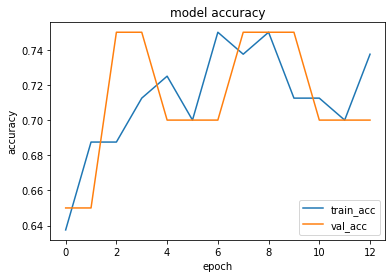

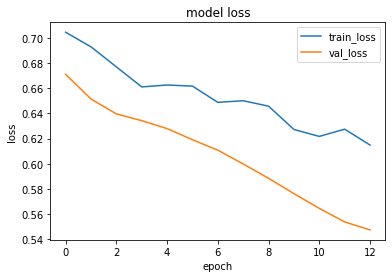

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.45098734]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_3.mov is [[0.5471057]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.28989106]]


1it [00:00, 14217.98it/s]


prediction for video control_1.mov is [[0.19840306]]


1it [00:00, 9776.93it/s]


prediction for video control_2.mov is [[0.7866026]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.26287702]]
Epoch 1/75
3/3 [==============================] - 1s 195ms/step - loss: 0.6941 - accuracy: 0.5875 - precision_85: 0.5616 - recall_85: 0.9762 - val_loss: 0.6905 - val_accuracy: 0.4500 - val_precision_85: 0.4211 - val_recall_85: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6684 - accuracy: 0.5875 - precision_85: 0.5616 - recall_85: 0.9762 - val_loss: 0.6917 - val_accuracy: 0.4000 - val_precision_85: 0.3889 - val_recall_85: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6602 - accuracy: 0.6000 - precision_85: 0.5676 - recall_85: 1.0000 - val_loss: 0.6939 - val_accuracy: 0.4000 - val_precision_85: 0.3889 - val_recall_85: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6288 - accuracy: 0.6125 - precision_85: 0.5753 - recall_85: 1.0000 - val_loss: 0.6969 - val_accuracy: 0.4000 - val_precision_85: 0.3889 - val_recall_85: 0.8750
Epoch 5/75


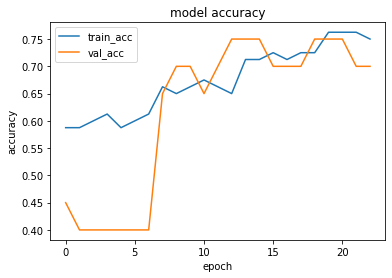

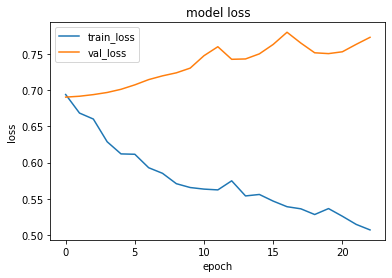

1it [00:00, 16320.25it/s]


prediction for video armflapping_1.mov is [[0.4512976]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.59370834]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.2511019]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.04705691]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.9234785]]


1it [00:00, 13486.51it/s]


prediction for video control_3.mov is [[0.18784961]]


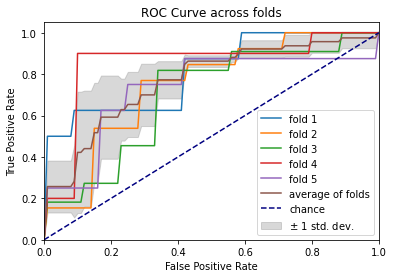

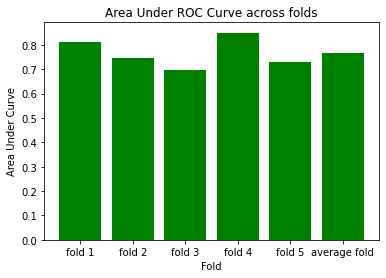

In [55]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 200ms/step - loss: 0.7030 - accuracy: 0.5000 - precision_87: 0.5152 - recall_87: 0.8095 - val_loss: 0.6888 - val_accuracy: 0.4000 - val_precision_87: 0.4000 - val_recall_87: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6710 - accuracy: 0.5500 - precision_87: 0.5395 - recall_87: 0.9762 - val_loss: 0.6728 - val_accuracy: 0.5000 - val_precision_87: 0.4444 - val_recall_87: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6657 - accuracy: 0.5750 - precision_87: 0.5541 - recall_87: 0.9762 - val_loss: 0.6556 - val_accuracy: 0.5000 - val_precision_87: 0.4444 - val_recall_87: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6509 - accuracy: 0.5875 - precision_87: 0.5616 - recall_87: 0.9762 - val_loss: 0.6382 - val_accuracy: 0.5000 - val_precision_87: 0.4444 - val_recall_87: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 133ms/step 

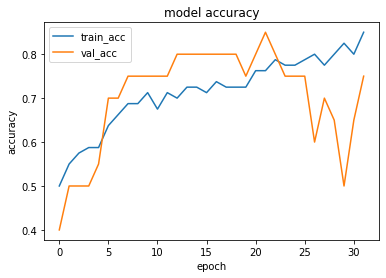

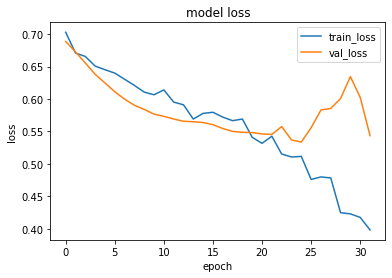

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.50252104]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.5918213]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_2.mov is [[0.24369055]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.15157068]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.8368163]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.29238677]]
Epoch 1/75
3/3 [==============================] - 1s 200ms/step - loss: 0.7032 - accuracy: 0.4625 - precision_88: 0.3636 - recall_88: 0.2162 - val_loss: 0.6926 - val_accuracy: 0.4000 - val_precision_88: 1.0000 - val_recall_88: 0.0769
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6823 - accuracy: 0.6500 - precision_88: 0.6957 - recall_88: 0.4324 - val_loss: 0.6749 - val_accuracy: 0.7500 - val_precision_88: 0.7857 - val_recall_88: 0.8462
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6727 - accuracy: 0.6625 - precision_88: 0.6471 - recall_88: 0.5946 - val_loss: 0.6619 - val_accuracy: 0.7500 - val_precision_88: 0.7857 - val_recall_88: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6669 - accuracy: 0.7250 - precision_88: 0.7027 - recall_88: 0.7027 - val_loss: 0.6503 - val_accuracy: 0.7500 - val_precision_88: 0.7857 - val_recall_88: 0.8462
Epoch 5/75


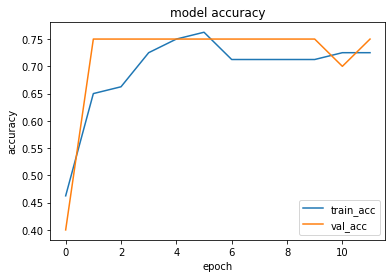

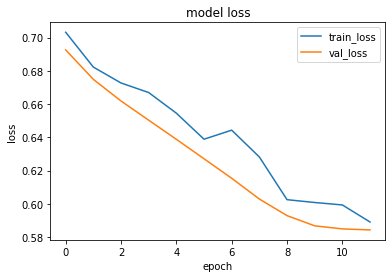

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.38414398]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5544027]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_2.mov is [[0.23411334]]


1it [00:00, 13148.29it/s]


prediction for video control_1.mov is [[0.13716918]]


1it [00:00, 13315.25it/s]


prediction for video control_2.mov is [[0.8424381]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.18314418]]
Epoch 1/75
3/3 [==============================] - 1s 215ms/step - loss: 0.7137 - accuracy: 0.3500 - precision_89: 0.3030 - recall_89: 0.2564 - val_loss: 0.6890 - val_accuracy: 0.5500 - val_precision_89: 0.5625 - val_recall_89: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6894 - accuracy: 0.5000 - precision_89: 0.4915 - recall_89: 0.7436 - val_loss: 0.6786 - val_accuracy: 0.6000 - val_precision_89: 0.5882 - val_recall_89: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6739 - accuracy: 0.5750 - precision_89: 0.5510 - recall_89: 0.6923 - val_loss: 0.6700 - val_accuracy: 0.6500 - val_precision_89: 0.6429 - val_recall_89: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6735 - accuracy: 0.6750 - precision_89: 0.6585 - recall_89: 0.6923 - val_loss: 0.6622 - val_accuracy: 0.6500 - val_precision_89: 0.6429 - val_recall_89: 0.8182
Epoch 5/75


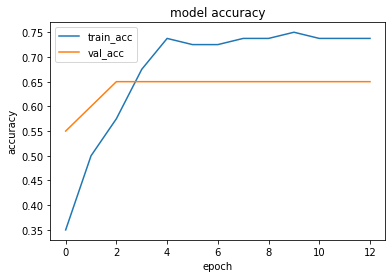

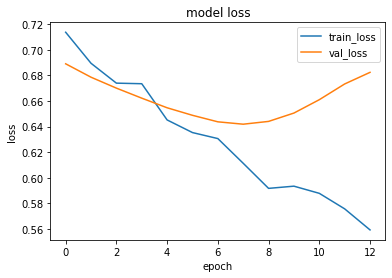

1it [00:00, 16448.25it/s]


prediction for video armflapping_1.mov is [[0.14552516]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.6187913]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.13619387]]


1it [00:00, 13357.66it/s]


prediction for video control_1.mov is [[0.07343164]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.8400017]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.11157143]]
Epoch 1/75
3/3 [==============================] - 1s 201ms/step - loss: 0.7212 - accuracy: 0.3500 - precision_90: 0.2273 - recall_90: 0.1250 - val_loss: 0.7142 - val_accuracy: 0.4000 - val_precision_90: 0.3333 - val_recall_90: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6878 - accuracy: 0.3500 - precision_90: 0.3421 - recall_90: 0.3250 - val_loss: 0.6942 - val_accuracy: 0.2500 - val_precision_90: 0.2727 - val_recall_90: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6777 - accuracy: 0.4750 - precision_90: 0.4815 - recall_90: 0.6500 - val_loss: 0.6779 - val_accuracy: 0.5000 - val_precision_90: 0.5000 - val_recall_90: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6684 - accuracy: 0.5500 - precision_90: 0.5323 - recall_90: 0.8250 - val_loss: 0.6636 - val_accuracy: 0.5500 - val_precision_90: 0.5294 - val_recall_90: 0.9000
Epoch 5/75


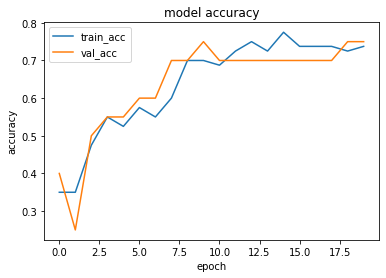

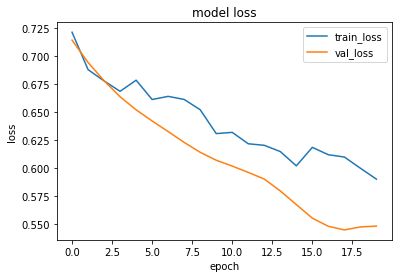

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.43225437]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.58945507]]


1it [00:00, 12052.60it/s]


prediction for video armflapping_2.mov is [[0.3860178]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.14564517]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.8005853]]


1it [00:00, 10754.63it/s]


prediction for video control_3.mov is [[0.26779252]]
Epoch 1/75
3/3 [==============================] - 1s 245ms/step - loss: 0.7186 - accuracy: 0.4000 - precision_91: 0.3846 - recall_91: 0.2381 - val_loss: 0.7098 - val_accuracy: 0.4000 - val_precision_91: 0.2500 - val_recall_91: 0.2500
Epoch 2/75
3/3 [==============================] - 0s 166ms/step - loss: 0.6942 - accuracy: 0.4250 - precision_91: 0.4583 - recall_91: 0.5238 - val_loss: 0.6984 - val_accuracy: 0.4500 - val_precision_91: 0.4118 - val_recall_91: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6657 - accuracy: 0.5625 - precision_91: 0.5593 - recall_91: 0.7857 - val_loss: 0.6950 - val_accuracy: 0.3500 - val_precision_91: 0.3684 - val_recall_91: 0.8750
Epoch 4/75
3/3 [==============================] - 1s 242ms/step - loss: 0.6435 - accuracy: 0.6000 - precision_91: 0.5735 - recall_91: 0.9286 - val_loss: 0.6948 - val_accuracy: 0.3500 - val_precision_91: 0.3684 - val_recall_91: 0.8750
Epoch 5/75


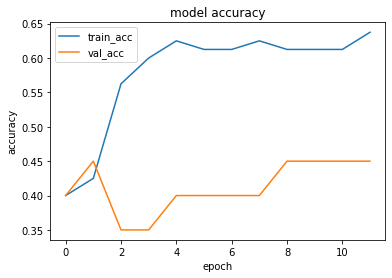

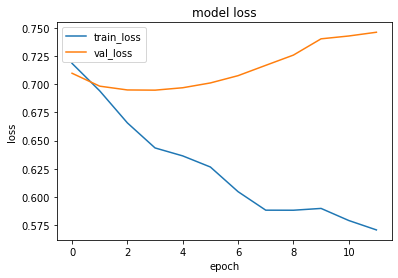

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.25156784]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.6191186]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.16652977]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.0810985]]


1it [00:00, 15087.42it/s]


prediction for video control_2.mov is [[0.87297773]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.11304697]]


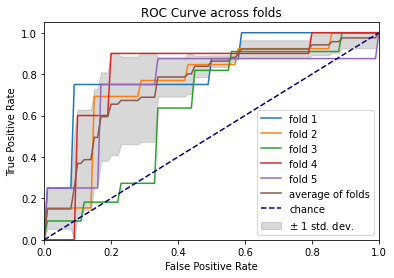

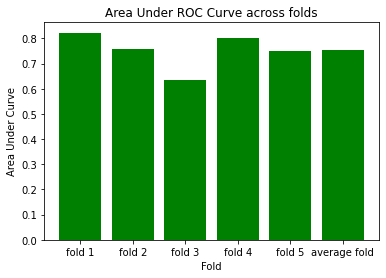

In [56]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 281ms/step - loss: 0.6954 - accuracy: 0.5250 - precision_93: 0.5323 - recall_93: 0.7857 - val_loss: 0.6795 - val_accuracy: 0.5000 - val_precision_93: 0.4444 - val_recall_93: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6722 - accuracy: 0.5375 - precision_93: 0.5352 - recall_93: 0.9048 - val_loss: 0.6650 - val_accuracy: 0.5000 - val_precision_93: 0.4444 - val_recall_93: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6627 - accuracy: 0.5500 - precision_93: 0.5429 - recall_93: 0.9048 - val_loss: 0.6544 - val_accuracy: 0.5000 - val_precision_93: 0.4444 - val_recall_93: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6492 - accuracy: 0.5625 - precision_93: 0.5479 - recall_93: 0.9524 - val_loss: 0.6410 - val_accuracy: 0.5000 - val_precision_93: 0.4444 - val_recall_93: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 159ms/step 

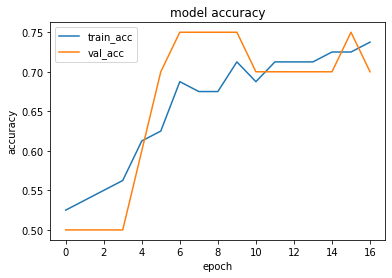

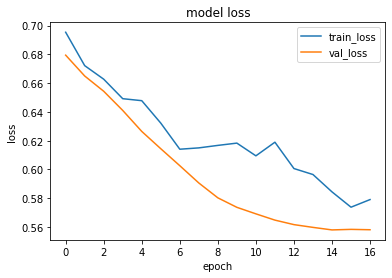

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.47007552]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.5393466]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.35718223]]


1it [00:00, 14027.77it/s]


prediction for video control_1.mov is [[0.22179699]]


1it [00:00, 15420.24it/s]


prediction for video control_2.mov is [[0.7413218]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.3079522]]
Epoch 1/75
3/3 [==============================] - 1s 245ms/step - loss: 0.7132 - accuracy: 0.3750 - precision_94: 0.2593 - recall_94: 0.1892 - val_loss: 0.7007 - val_accuracy: 0.4000 - val_precision_94: 0.6000 - val_recall_94: 0.2308
Epoch 2/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6998 - accuracy: 0.5125 - precision_94: 0.4643 - recall_94: 0.3514 - val_loss: 0.6842 - val_accuracy: 0.8000 - val_precision_94: 0.8462 - val_recall_94: 0.8462
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6813 - accuracy: 0.6375 - precision_94: 0.6111 - recall_94: 0.5946 - val_loss: 0.6684 - val_accuracy: 0.7500 - val_precision_94: 0.7857 - val_recall_94: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6689 - accuracy: 0.7000 - precision_94: 0.6383 - recall_94: 0.8108 - val_loss: 0.6536 - val_accuracy: 0.7500 - val_precision_94: 0.7857 - val_recall_94: 0.8462
Epoch 5/75
3

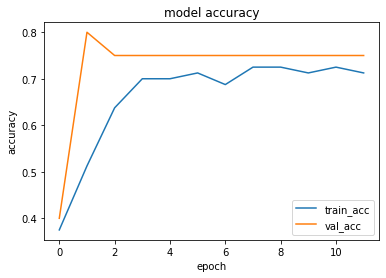

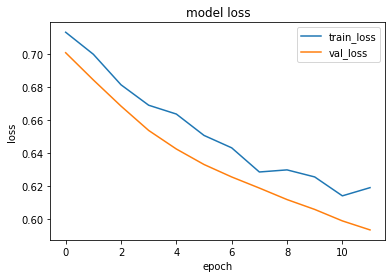

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.49159944]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5048529]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.47986913]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.4964161]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.5098506]]


1it [00:00, 14027.77it/s]


prediction for video control_3.mov is [[0.4793306]]
Epoch 1/75
3/3 [==============================] - 1s 223ms/step - loss: 0.6766 - accuracy: 0.5125 - precision_95: 0.5000 - recall_95: 0.9744 - val_loss: 0.6647 - val_accuracy: 0.6000 - val_precision_95: 0.5882 - val_recall_95: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6587 - accuracy: 0.6750 - precision_95: 0.6275 - recall_95: 0.8205 - val_loss: 0.6530 - val_accuracy: 0.6000 - val_precision_95: 0.6000 - val_recall_95: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6559 - accuracy: 0.7125 - precision_95: 0.6905 - recall_95: 0.7436 - val_loss: 0.6460 - val_accuracy: 0.7500 - val_precision_95: 0.7500 - val_recall_95: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6518 - accuracy: 0.6625 - precision_95: 0.6429 - recall_95: 0.6923 - val_loss: 0.6402 - val_accuracy: 0.7500 - val_precision_95: 0.7500 - val_recall_95: 0.8182
Epoch 5/75
3

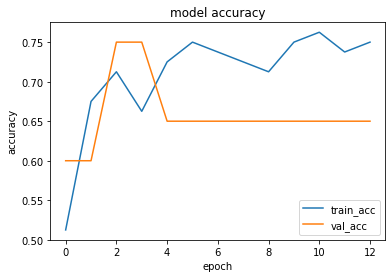

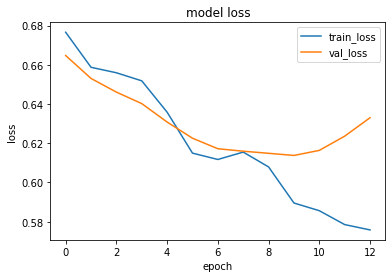

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.20241323]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.5837567]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.16188395]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.0956555]]


1it [00:00, 16070.13it/s]


prediction for video control_2.mov is [[0.8717307]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.13161922]]
Epoch 1/75
3/3 [==============================] - 1s 200ms/step - loss: 0.6845 - accuracy: 0.5375 - precision_96: 0.5238 - recall_96: 0.8250 - val_loss: 0.6540 - val_accuracy: 0.7000 - val_precision_96: 0.6429 - val_recall_96: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6616 - accuracy: 0.6875 - precision_96: 0.6471 - recall_96: 0.8250 - val_loss: 0.6415 - val_accuracy: 0.7000 - val_precision_96: 0.6429 - val_recall_96: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6550 - accuracy: 0.7125 - precision_96: 0.6809 - recall_96: 0.8000 - val_loss: 0.6307 - val_accuracy: 0.7000 - val_precision_96: 0.6429 - val_recall_96: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6431 - accuracy: 0.6750 - precision_96: 0.6296 - recall_96: 0.8500 - val_loss: 0.6208 - val_accuracy: 0.7000 - val_precision_96: 0.6429 - val_recall_96: 0.9000
Epoch 5/75


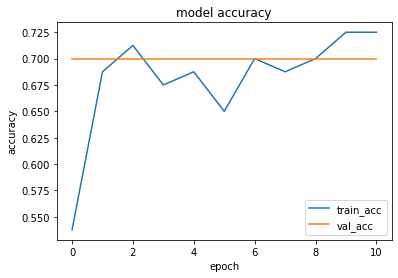

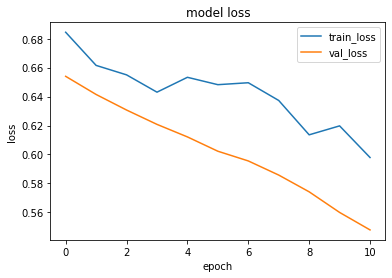

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.40635204]]


1it [00:00, 13662.23it/s]


prediction for video armflapping_3.mov is [[0.5481978]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.27658013]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.15100628]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.7697226]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.18776926]]
Epoch 1/75
3/3 [==============================] - 1s 224ms/step - loss: 0.6760 - accuracy: 0.6375 - precision_97: 0.6140 - recall_97: 0.8333 - val_loss: 0.6938 - val_accuracy: 0.6000 - val_precision_97: 0.5000 - val_recall_97: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6591 - accuracy: 0.6000 - precision_97: 0.5781 - recall_97: 0.8810 - val_loss: 0.6969 - val_accuracy: 0.3500 - val_precision_97: 0.3684 - val_recall_97: 0.8750
Epoch 3/75
3/3 [==============================] - 1s 233ms/step - loss: 0.6499 - accuracy: 0.6000 - precision_97: 0.5714 - recall_97: 0.9524 - val_loss: 0.7006 - val_accuracy: 0.3500 - val_precision_97: 0.3684 - val_recall_97: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6336 - accuracy: 0.6125 - precision_97: 0.5753 - recall_97: 1.0000 - val_loss: 0.7043 - val_accuracy: 0.3500 - val_precision_97: 0.3684 - val_recall_97: 0.8750
Epoch 5/75


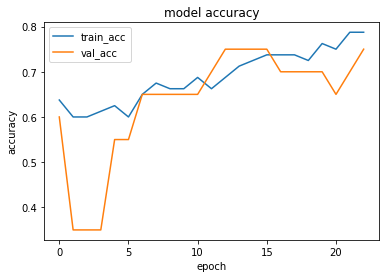

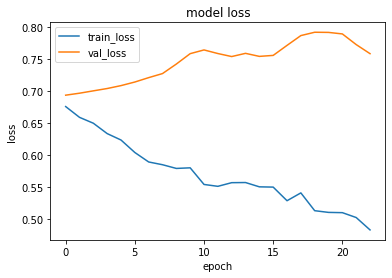

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.42265353]]


1it [00:00, 11915.64it/s]


prediction for video armflapping_3.mov is [[0.58752704]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.285963]]


1it [00:00, 13315.25it/s]


prediction for video control_1.mov is [[0.04425102]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.9249341]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.17069039]]


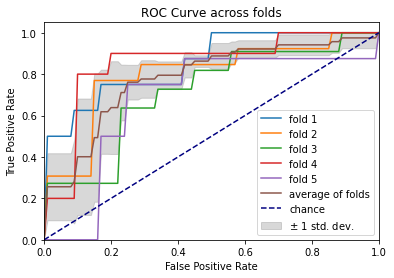

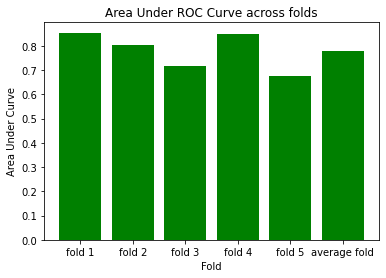

In [57]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 258ms/step - loss: 0.6925 - accuracy: 0.4250 - precision_99: 0.4444 - recall_99: 0.3810 - val_loss: 0.6683 - val_accuracy: 0.5000 - val_precision_99: 0.4375 - val_recall_99: 0.8750
Epoch 2/75
3/3 [==============================] - 1s 206ms/step - loss: 0.6773 - accuracy: 0.4625 - precision_99: 0.4918 - recall_99: 0.7143 - val_loss: 0.6699 - val_accuracy: 0.5000 - val_precision_99: 0.4444 - val_recall_99: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 177ms/step - loss: 0.6572 - accuracy: 0.5500 - precision_99: 0.5405 - recall_99: 0.9524 - val_loss: 0.6728 - val_accuracy: 0.5000 - val_precision_99: 0.4444 - val_recall_99: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 172ms/step - loss: 0.6551 - accuracy: 0.5500 - precision_99: 0.5395 - recall_99: 0.9762 - val_loss: 0.6659 - val_accuracy: 0.5000 - val_precision_99: 0.4444 - val_recall_99: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 166ms/step 

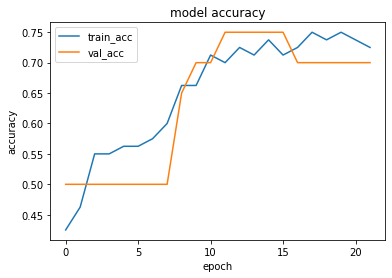

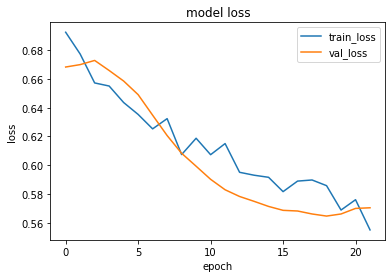

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.37092954]]


1it [00:00, 9446.63it/s]


prediction for video armflapping_3.mov is [[0.5473068]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.2984255]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.14330012]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.782437]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.18855444]]
Epoch 1/75
3/3 [==============================] - 1s 277ms/step - loss: 0.6977 - accuracy: 0.5125 - precision_100: 0.4375 - recall_100: 0.1892 - val_loss: 0.7055 - val_accuracy: 0.3500 - val_precision_100: 0.0000e+00 - val_recall_100: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 178ms/step - loss: 0.6742 - accuracy: 0.6875 - precision_100: 0.7308 - recall_100: 0.5135 - val_loss: 0.6808 - val_accuracy: 0.5000 - val_precision_100: 0.8000 - val_recall_100: 0.3077
Epoch 3/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6675 - accuracy: 0.6750 - precision_100: 0.6774 - recall_100: 0.5676 - val_loss: 0.6598 - val_accuracy: 0.7500 - val_precision_100: 0.7857 - val_recall_100: 0.8462
Epoch 4/75
3/3 [==============================] - 1s 190ms/step - loss: 0.6636 - accuracy: 0.7000 - precision_100: 0.6857 - recall_100: 0.6486 - val_loss: 0.6414 - val_accuracy: 0.7500 - val_precision_100: 0.7857 - val_recall

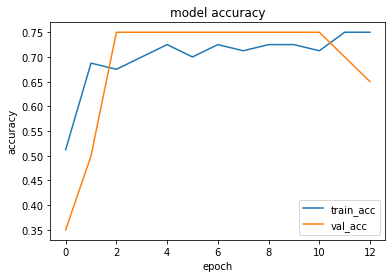

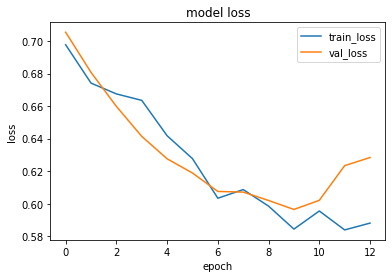

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.2492778]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.54150724]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.15883952]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.12218058]]


1it [00:00, 19691.57it/s]


prediction for video control_2.mov is [[0.7949134]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.1284487]]
Epoch 1/75
3/3 [==============================] - 1s 259ms/step - loss: 0.6707 - accuracy: 0.6750 - precision_101: 0.6226 - recall_101: 0.8462 - val_loss: 0.6610 - val_accuracy: 0.6500 - val_precision_101: 0.6250 - val_recall_101: 0.9091
Epoch 2/75
3/3 [==============================] - 1s 193ms/step - loss: 0.6540 - accuracy: 0.6875 - precision_101: 0.6522 - recall_101: 0.7692 - val_loss: 0.6520 - val_accuracy: 0.6000 - val_precision_101: 0.6000 - val_recall_101: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6556 - accuracy: 0.7125 - precision_101: 0.6667 - recall_101: 0.8205 - val_loss: 0.6449 - val_accuracy: 0.6000 - val_precision_101: 0.6000 - val_recall_101: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6464 - accuracy: 0.6875 - precision_101: 0.6522 - recall_101: 0.7692 - val_loss: 0.6385 - val_accuracy: 0.6000 - val_precision_101: 0.6000 - val_recall_101: 0.8

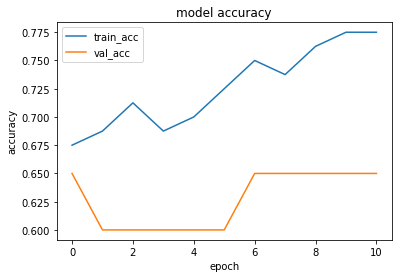

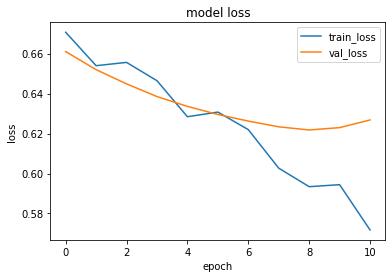

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.25022277]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_3.mov is [[0.5536612]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.16595566]]


1it [00:00, 13148.29it/s]


prediction for video control_1.mov is [[0.10115552]]


1it [00:00, 15827.56it/s]


prediction for video control_2.mov is [[0.80232424]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.14192754]]
Epoch 1/75
3/3 [==============================] - 1s 210ms/step - loss: 0.6966 - accuracy: 0.4250 - precision_102: 0.4545 - recall_102: 0.7500 - val_loss: 0.6656 - val_accuracy: 0.6000 - val_precision_102: 0.5556 - val_recall_102: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6665 - accuracy: 0.5375 - precision_102: 0.5217 - recall_102: 0.9000 - val_loss: 0.6496 - val_accuracy: 0.6000 - val_precision_102: 0.5556 - val_recall_102: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6508 - accuracy: 0.5875 - precision_102: 0.5507 - recall_102: 0.9500 - val_loss: 0.6350 - val_accuracy: 0.6000 - val_precision_102: 0.5556 - val_recall_102: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6598 - accuracy: 0.5875 - precision_102: 0.5479 - recall_102: 1.0000 - val_loss: 0.6210 - val_accuracy: 0.6000 - val_precision_102: 0.5625 - val_recall_102: 0.

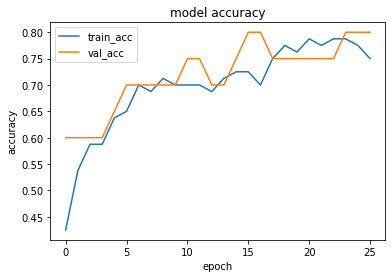

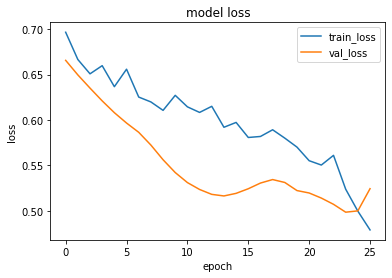

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.3874995]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.5756227]]


1it [00:00, 21845.33it/s]


prediction for video armflapping_2.mov is [[0.34053963]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.15495768]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.82252514]]


1it [00:00, 11244.78it/s]


prediction for video control_3.mov is [[0.2585588]]
Epoch 1/75
3/3 [==============================] - 1s 226ms/step - loss: 0.6947 - accuracy: 0.4500 - precision_103: 0.4643 - recall_103: 0.3095 - val_loss: 0.7150 - val_accuracy: 0.2000 - val_precision_103: 0.1667 - val_recall_103: 0.2500
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6724 - accuracy: 0.5625 - precision_103: 0.5574 - recall_103: 0.8095 - val_loss: 0.7096 - val_accuracy: 0.3000 - val_precision_103: 0.3333 - val_recall_103: 0.7500
Epoch 3/75
3/3 [==============================] - 1s 213ms/step - loss: 0.6619 - accuracy: 0.5750 - precision_103: 0.5588 - recall_103: 0.9048 - val_loss: 0.7102 - val_accuracy: 0.3500 - val_precision_103: 0.3684 - val_recall_103: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6490 - accuracy: 0.5750 - precision_103: 0.5556 - recall_103: 0.9524 - val_loss: 0.7129 - val_accuracy: 0.3500 - val_precision_103: 0.3684 - val_recall_103: 0.8

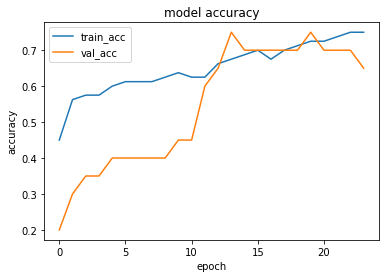

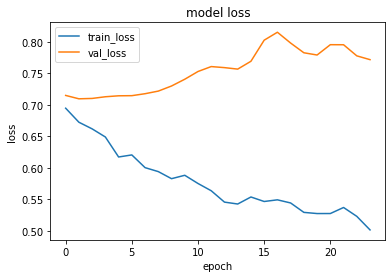

1it [00:00, 16320.25it/s]


prediction for video armflapping_1.mov is [[0.3753007]]


1it [00:00, 12787.51it/s]


prediction for video armflapping_3.mov is [[0.6045708]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.22890922]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.03351939]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.9088074]]


1it [00:00, 8594.89it/s]


prediction for video control_3.mov is [[0.15625033]]


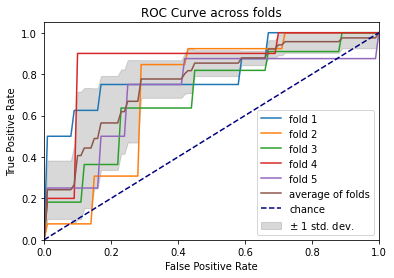

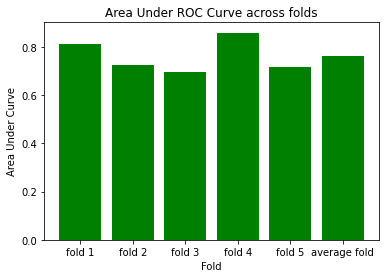

In [58]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.7220 - accuracy: 0.3250 - precision_105: 0.2000 - recall_105: 0.0952 - val_loss: 0.6861 - val_accuracy: 0.5000 - val_precision_105: 0.4375 - val_recall_105: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6875 - accuracy: 0.4625 - precision_105: 0.4912 - recall_105: 0.6667 - val_loss: 0.6848 - val_accuracy: 0.4500 - val_precision_105: 0.4211 - val_recall_105: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6806 - accuracy: 0.5250 - precision_105: 0.5278 - recall_105: 0.9048 - val_loss: 0.6846 - val_accuracy: 0.4000 - val_precision_105: 0.4000 - val_recall_105: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6719 - accuracy: 0.5625 - precision_105: 0.5455 - recall_105: 1.0000 - val_loss: 0.6819 - val_accuracy: 0.4000 - val_precision_105: 0.4000 - val_recall_105: 1.0000
Epoch 5/75
3/3 [==============================] 

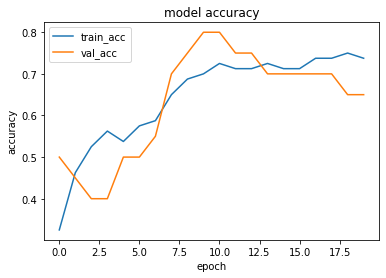

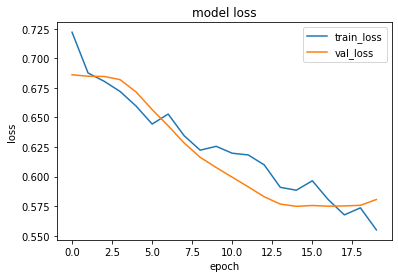

1it [00:00, 9619.96it/s]


prediction for video armflapping_1.mov is [[0.46207964]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.5399546]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.32507753]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.25418508]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.71153027]]


1it [00:00, 11748.75it/s]


prediction for video control_3.mov is [[0.2891597]]
Epoch 1/75
3/3 [==============================] - 1s 227ms/step - loss: 0.7256 - accuracy: 0.3125 - precision_106: 0.2632 - recall_106: 0.2703 - val_loss: 0.6898 - val_accuracy: 0.5500 - val_precision_106: 0.6667 - val_recall_106: 0.6154
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7026 - accuracy: 0.3625 - precision_106: 0.3871 - recall_106: 0.6486 - val_loss: 0.6631 - val_accuracy: 0.7000 - val_precision_106: 0.6842 - val_recall_106: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6754 - accuracy: 0.6250 - precision_106: 0.5686 - recall_106: 0.7838 - val_loss: 0.6451 - val_accuracy: 0.7500 - val_precision_106: 0.7857 - val_recall_106: 0.8462
Epoch 4/75
3/3 [==============================] - 1s 223ms/step - loss: 0.6691 - accuracy: 0.6625 - precision_106: 0.5962 - recall_106: 0.8378 - val_loss: 0.6322 - val_accuracy: 0.7500 - val_precision_106: 0.7857 - val_recall_106: 0.8

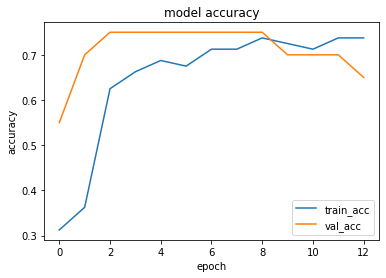

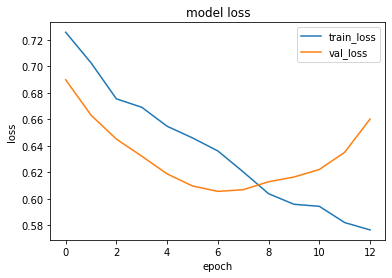

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.19190726]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.5520232]]


1it [00:00, 8924.05it/s]


prediction for video armflapping_2.mov is [[0.15795654]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.11529255]]


1it [00:00, 12945.38it/s]


prediction for video control_2.mov is [[0.81486034]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.12798229]]
Epoch 1/75
3/3 [==============================] - 1s 340ms/step - loss: 0.7060 - accuracy: 0.4750 - precision_107: 0.4483 - recall_107: 0.3333 - val_loss: 0.6949 - val_accuracy: 0.4000 - val_precision_107: 0.0000e+00 - val_recall_107: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6810 - accuracy: 0.5625 - precision_107: 0.5588 - recall_107: 0.4872 - val_loss: 0.6802 - val_accuracy: 0.6000 - val_precision_107: 0.5882 - val_recall_107: 0.9091
Epoch 3/75
3/3 [==============================] - 1s 197ms/step - loss: 0.6785 - accuracy: 0.6375 - precision_107: 0.6087 - recall_107: 0.7179 - val_loss: 0.6689 - val_accuracy: 0.6500 - val_precision_107: 0.6250 - val_recall_107: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 172ms/step - loss: 0.6605 - accuracy: 0.6750 - precision_107: 0.6275 - recall_107: 0.8205 - val_loss: 0.6581 - val_accuracy: 0.6000 - val_precision_107: 0.6000 - val_recall

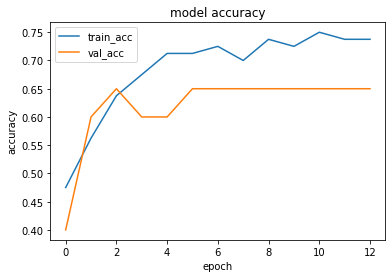

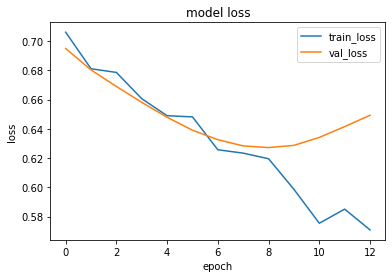

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.21726999]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.60439014]]


1it [00:00, 11335.96it/s]


prediction for video armflapping_2.mov is [[0.15892005]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.13397604]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.83558244]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.14871913]]
Epoch 1/75
3/3 [==============================] - 1s 247ms/step - loss: 0.6959 - accuracy: 0.3875 - precision_108: 0.3548 - recall_108: 0.2750 - val_loss: 0.6708 - val_accuracy: 0.6000 - val_precision_108: 0.5556 - val_recall_108: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6766 - accuracy: 0.5875 - precision_108: 0.5614 - recall_108: 0.8000 - val_loss: 0.6474 - val_accuracy: 0.6000 - val_precision_108: 0.5556 - val_recall_108: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6632 - accuracy: 0.6250 - precision_108: 0.5806 - recall_108: 0.9000 - val_loss: 0.6292 - val_accuracy: 0.6500 - val_precision_108: 0.6000 - val_recall_108: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6575 - accuracy: 0.6500 - precision_108: 0.6071 - recall_108: 0.8500 - val_loss: 0.6138 - val_accuracy: 0.7000 - val_precision_108: 0.6429 - val_recall_108: 0.

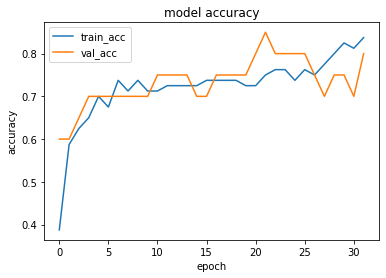

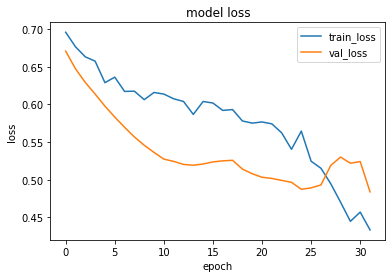

1it [00:00, 8192.00it/s]


prediction for video armflapping_1.mov is [[0.35143894]]


1it [00:00, 15087.42it/s]


prediction for video armflapping_3.mov is [[0.5454639]]


1it [00:00, 9619.96it/s]


prediction for video armflapping_2.mov is [[0.26126242]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.12971419]]


1it [00:00, 15196.75it/s]


prediction for video control_2.mov is [[0.7819197]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.26122686]]
Epoch 1/75
3/3 [==============================] - 1s 274ms/step - loss: 0.7106 - accuracy: 0.4875 - precision_109: 0.5098 - recall_109: 0.6190 - val_loss: 0.6966 - val_accuracy: 0.4000 - val_precision_109: 0.3889 - val_recall_109: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6720 - accuracy: 0.5625 - precision_109: 0.5556 - recall_109: 0.8333 - val_loss: 0.6977 - val_accuracy: 0.4500 - val_precision_109: 0.4118 - val_recall_109: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6618 - accuracy: 0.5500 - precision_109: 0.5469 - recall_109: 0.8333 - val_loss: 0.6981 - val_accuracy: 0.4500 - val_precision_109: 0.4118 - val_recall_109: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6515 - accuracy: 0.5750 - precision_109: 0.5588 - recall_109: 0.9048 - val_loss: 0.6990 - val_accuracy: 0.4000 - val_precision_109: 0.3889 - val_recall_109: 0.

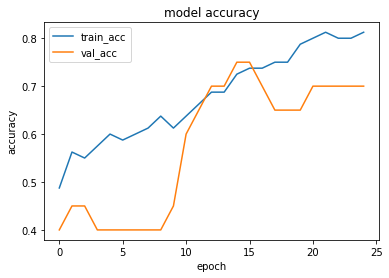

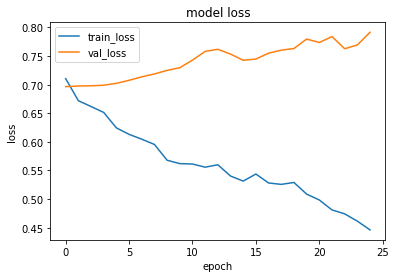

1it [00:00, 12865.96it/s]


prediction for video armflapping_1.mov is [[0.8836734]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.6816547]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_2.mov is [[0.79851246]]


1it [00:00, 12520.31it/s]


prediction for video control_1.mov is [[0.03784937]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.9051738]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.77712554]]


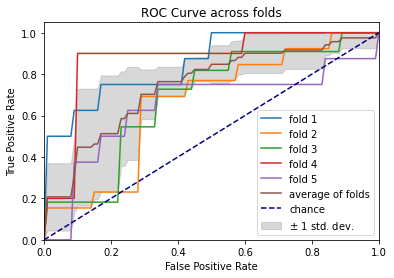

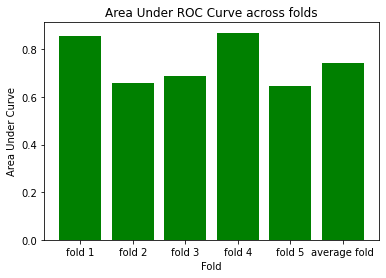

In [59]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 257ms/step - loss: 0.7076 - accuracy: 0.3875 - precision_111: 0.4186 - recall_111: 0.4286 - val_loss: 0.6964 - val_accuracy: 0.4000 - val_precision_111: 0.3750 - val_recall_111: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.7108 - accuracy: 0.4125 - precision_111: 0.4590 - recall_111: 0.6667 - val_loss: 0.6902 - val_accuracy: 0.4500 - val_precision_111: 0.4211 - val_recall_111: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6809 - accuracy: 0.5750 - precision_111: 0.5556 - recall_111: 0.9524 - val_loss: 0.6789 - val_accuracy: 0.5000 - val_precision_111: 0.4444 - val_recall_111: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 239ms/step - loss: 0.6787 - accuracy: 0.5625 - precision_111: 0.5479 - recall_111: 0.9524 - val_loss: 0.6678 - val_accuracy: 0.5000 - val_precision_111: 0.4444 - val_recall_111: 1.0000
Epoch 5/75
3/3 [==============================] 

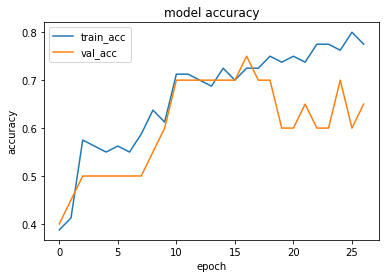

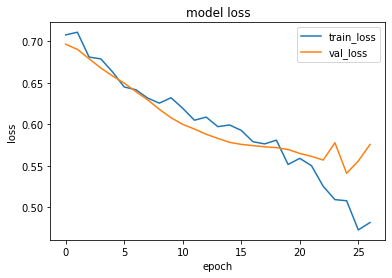

1it [00:00, 8388.61it/s]


prediction for video armflapping_1.mov is [[0.2970568]]


1it [00:00, 8338.58it/s]


prediction for video armflapping_3.mov is [[0.5456144]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.23094389]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.1430332]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.8188983]]


1it [00:00, 7530.17it/s]


prediction for video control_3.mov is [[0.16526452]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6931 - accuracy: 0.4000 - precision_112: 0.3721 - recall_112: 0.4324 - val_loss: 0.6791 - val_accuracy: 0.6500 - val_precision_112: 0.7143 - val_recall_112: 0.7692
Epoch 2/75
3/3 [==============================] - 1s 206ms/step - loss: 0.6827 - accuracy: 0.4750 - precision_112: 0.4576 - recall_112: 0.7297 - val_loss: 0.6583 - val_accuracy: 0.7000 - val_precision_112: 0.7333 - val_recall_112: 0.8462
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6730 - accuracy: 0.6750 - precision_112: 0.6038 - recall_112: 0.8649 - val_loss: 0.6443 - val_accuracy: 0.7500 - val_precision_112: 0.7857 - val_recall_112: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6582 - accuracy: 0.6625 - precision_112: 0.6000 - recall_112: 0.8108 - val_loss: 0.6320 - val_accuracy: 0.7500 - val_precision_112: 0.7857 - val_recall_112: 0.

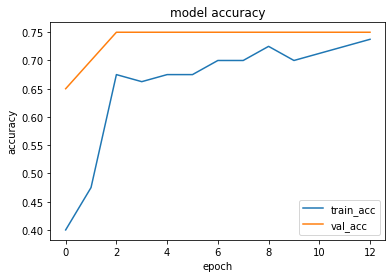

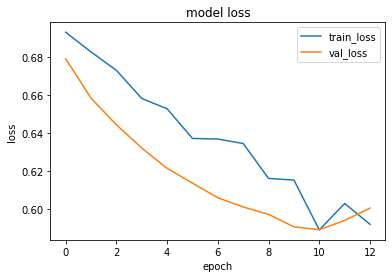

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.276802]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.5658212]]


1it [00:00, 10894.30it/s]


prediction for video armflapping_2.mov is [[0.20593864]]


1it [00:00, 8701.88it/s]


prediction for video control_1.mov is [[0.11948761]]


1it [00:00, 13934.56it/s]


prediction for video control_2.mov is [[0.80093867]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.14023921]]
Epoch 1/75
3/3 [==============================] - 1s 220ms/step - loss: 0.6909 - accuracy: 0.4750 - precision_113: 0.4737 - recall_113: 0.6923 - val_loss: 0.6695 - val_accuracy: 0.5500 - val_precision_113: 0.5556 - val_recall_113: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6700 - accuracy: 0.5625 - precision_113: 0.5333 - recall_113: 0.8205 - val_loss: 0.6575 - val_accuracy: 0.6500 - val_precision_113: 0.6429 - val_recall_113: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6574 - accuracy: 0.6000 - precision_113: 0.5686 - recall_113: 0.7436 - val_loss: 0.6471 - val_accuracy: 0.6000 - val_precision_113: 0.6000 - val_recall_113: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6399 - accuracy: 0.6625 - precision_113: 0.6111 - recall_113: 0.8462 - val_loss: 0.6413 - val_accuracy: 0.6500 - val_precision_113: 0.6429 - val_recall_113: 0.

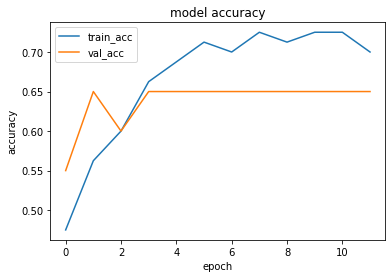

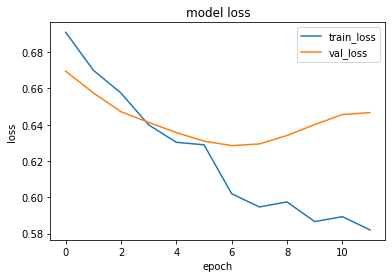

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.19595394]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.61411107]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_2.mov is [[0.16100603]]


1it [00:00, 13315.25it/s]


prediction for video control_1.mov is [[0.11057141]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.8649256]]


1it [00:00, 15477.14it/s]


prediction for video control_3.mov is [[0.12744424]]
Epoch 1/75
3/3 [==============================] - 1s 201ms/step - loss: 0.7062 - accuracy: 0.5625 - precision_114: 0.5385 - recall_114: 0.8750 - val_loss: 0.6826 - val_accuracy: 0.6500 - val_precision_114: 0.6000 - val_recall_114: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6906 - accuracy: 0.6000 - precision_114: 0.5714 - recall_114: 0.8000 - val_loss: 0.6638 - val_accuracy: 0.7000 - val_precision_114: 0.6429 - val_recall_114: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6857 - accuracy: 0.6750 - precision_114: 0.6346 - recall_114: 0.8250 - val_loss: 0.6477 - val_accuracy: 0.7500 - val_precision_114: 0.6923 - val_recall_114: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6673 - accuracy: 0.7000 - precision_114: 0.6739 - recall_114: 0.7750 - val_loss: 0.6336 - val_accuracy: 0.7500 - val_precision_114: 0.6923 - val_recall_114: 0.

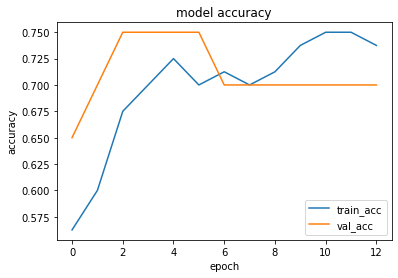

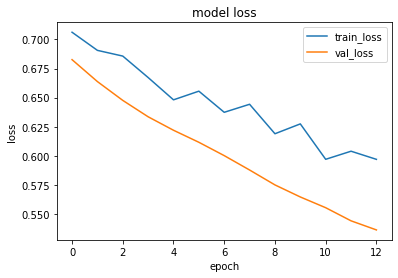

1it [00:00, 16070.13it/s]


prediction for video armflapping_1.mov is [[0.38459048]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.55591446]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.26268762]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.12900865]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.79317296]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.22263649]]
Epoch 1/75
3/3 [==============================] - 1s 203ms/step - loss: 0.7028 - accuracy: 0.4875 - precision_115: 0.5116 - recall_115: 0.5238 - val_loss: 0.7001 - val_accuracy: 0.4000 - val_precision_115: 0.3889 - val_recall_115: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6731 - accuracy: 0.5625 - precision_115: 0.5522 - recall_115: 0.8810 - val_loss: 0.6991 - val_accuracy: 0.4000 - val_precision_115: 0.3889 - val_recall_115: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6525 - accuracy: 0.5875 - precision_115: 0.5634 - recall_115: 0.9524 - val_loss: 0.7022 - val_accuracy: 0.4000 - val_precision_115: 0.3889 - val_recall_115: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6353 - accuracy: 0.6125 - precision_115: 0.5775 - recall_115: 0.9762 - val_loss: 0.7077 - val_accuracy: 0.4000 - val_precision_115: 0.3889 - val_recall_115: 0.

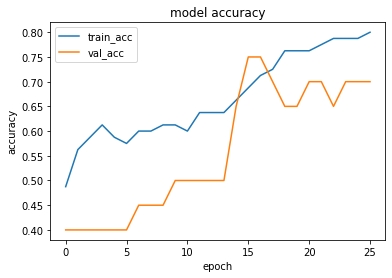

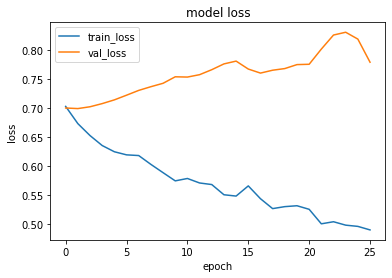

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.7863991]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.6119081]]


1it [00:00, 8473.34it/s]


prediction for video armflapping_2.mov is [[0.41707397]]


1it [00:00, 17331.83it/s]


prediction for video control_1.mov is [[0.05624682]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.92705345]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.6433439]]


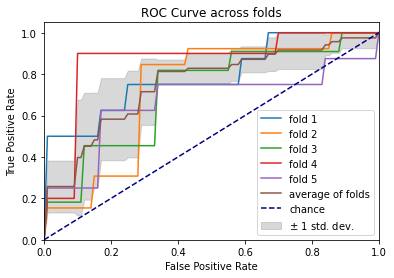

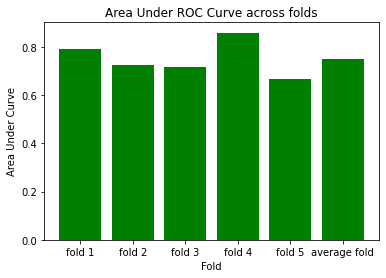

In [60]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6966 - accuracy: 0.5375 - precision_117: 0.5510 - recall_117: 0.6429 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_precision_117: 0.4286 - val_recall_117: 0.7500
Epoch 2/75
3/3 [==============================] - 1s 202ms/step - loss: 0.6904 - accuracy: 0.6375 - precision_117: 0.6102 - recall_117: 0.8571 - val_loss: 0.6835 - val_accuracy: 0.6000 - val_precision_117: 0.5000 - val_recall_117: 0.7500
Epoch 3/75
3/3 [==============================] - 1s 194ms/step - loss: 0.6613 - accuracy: 0.6750 - precision_117: 0.6379 - recall_117: 0.8810 - val_loss: 0.6740 - val_accuracy: 0.7000 - val_precision_117: 0.6000 - val_recall_117: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 221ms/step - loss: 0.6559 - accuracy: 0.6875 - precision_117: 0.6491 - recall_117: 0.8810 - val_loss: 0.6671 - val_accuracy: 0.6000 - val_precision_117: 0.5000 - val_recall_117: 0.7500
Epoch 5/75
3/3 [==============================] 

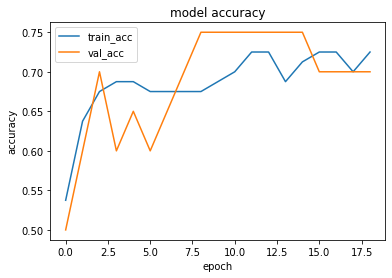

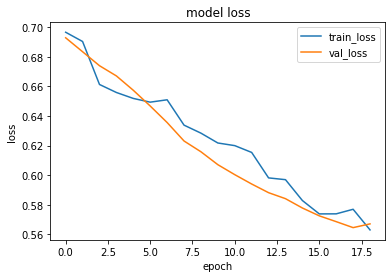

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.4642592]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.52639425]]


1it [00:00, 11915.64it/s]


prediction for video armflapping_2.mov is [[0.3683088]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.23549902]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.6849284]]


1it [00:00, 9177.91it/s]


prediction for video control_3.mov is [[0.29448715]]
Epoch 1/75
3/3 [==============================] - 1s 265ms/step - loss: 0.7006 - accuracy: 0.6000 - precision_118: 0.5510 - recall_118: 0.7297 - val_loss: 0.6793 - val_accuracy: 0.6000 - val_precision_118: 0.7273 - val_recall_118: 0.6154
Epoch 2/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6841 - accuracy: 0.6625 - precision_118: 0.6250 - recall_118: 0.6757 - val_loss: 0.6689 - val_accuracy: 0.7000 - val_precision_118: 0.8182 - val_recall_118: 0.6923
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6678 - accuracy: 0.7375 - precision_118: 0.7105 - recall_118: 0.7297 - val_loss: 0.6618 - val_accuracy: 0.7000 - val_precision_118: 0.8182 - val_recall_118: 0.6923
Epoch 4/75
3/3 [==============================] - 1s 214ms/step - loss: 0.6612 - accuracy: 0.7250 - precision_118: 0.7027 - recall_118: 0.7027 - val_loss: 0.6562 - val_accuracy: 0.7000 - val_precision_118: 0.8182 - val_recall_118: 0.

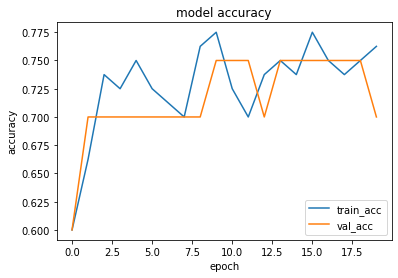

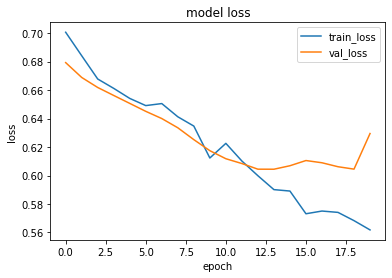

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.17616075]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_3.mov is [[0.5455117]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.10896215]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.11797038]]


1it [00:00, 13357.66it/s]


prediction for video control_2.mov is [[0.84287536]]


1it [00:00, 17260.51it/s]


prediction for video control_3.mov is [[0.1198926]]
Epoch 1/75
3/3 [==============================] - 1s 220ms/step - loss: 0.7075 - accuracy: 0.4500 - precision_119: 0.4576 - recall_119: 0.6923 - val_loss: 0.6864 - val_accuracy: 0.6000 - val_precision_119: 0.5882 - val_recall_119: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6794 - accuracy: 0.7375 - precision_119: 0.6875 - recall_119: 0.8462 - val_loss: 0.6755 - val_accuracy: 0.6500 - val_precision_119: 0.6250 - val_recall_119: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6744 - accuracy: 0.6875 - precision_119: 0.6522 - recall_119: 0.7692 - val_loss: 0.6657 - val_accuracy: 0.6500 - val_precision_119: 0.6250 - val_recall_119: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6768 - accuracy: 0.7000 - precision_119: 0.6829 - recall_119: 0.7179 - val_loss: 0.6576 - val_accuracy: 0.7000 - val_precision_119: 0.6667 - val_recall_119: 0.9

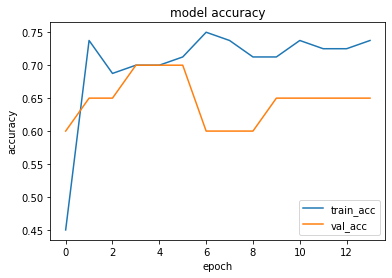

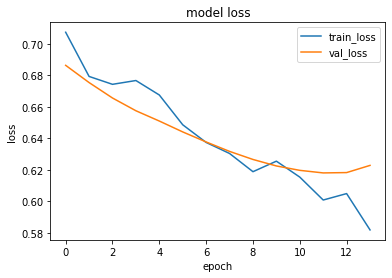

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.28364265]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.577914]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.20622575]]


1it [00:00, 12372.58it/s]


prediction for video control_1.mov is [[0.1299277]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.82087135]]


1it [00:00, 5645.09it/s]


prediction for video control_3.mov is [[0.16677189]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.7096 - accuracy: 0.5250 - precision_120: 0.5135 - recall_120: 0.9500 - val_loss: 0.6853 - val_accuracy: 0.6000 - val_precision_120: 0.5625 - val_recall_120: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 132ms/step - loss: 0.6810 - accuracy: 0.6750 - precision_120: 0.6296 - recall_120: 0.8500 - val_loss: 0.6636 - val_accuracy: 0.7500 - val_precision_120: 0.6923 - val_recall_120: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6646 - accuracy: 0.7000 - precision_120: 0.7000 - recall_120: 0.7000 - val_loss: 0.6531 - val_accuracy: 0.7500 - val_precision_120: 0.7778 - val_recall_120: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6578 - accuracy: 0.7000 - precision_120: 0.7222 - recall_120: 0.6500 - val_loss: 0.6422 - val_accuracy: 0.7500 - val_precision_120: 0.7778 - val_recall_120: 0.

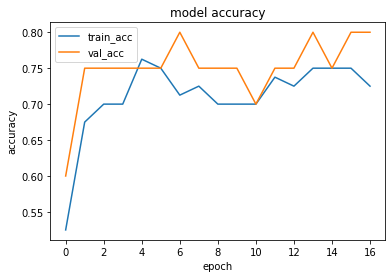

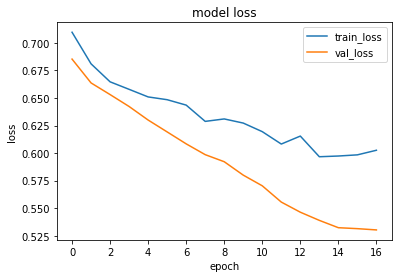

1it [00:00, 10305.42it/s]


prediction for video armflapping_1.mov is [[0.47188705]]


1it [00:00, 11915.64it/s]


prediction for video armflapping_3.mov is [[0.5177139]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.4268734]]


1it [00:00, 11244.78it/s]


prediction for video control_1.mov is [[0.21433645]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.67302024]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.28108126]]
Epoch 1/75
3/3 [==============================] - 1s 242ms/step - loss: 0.6922 - accuracy: 0.5750 - precision_121: 0.5769 - recall_121: 0.7143 - val_loss: 0.6776 - val_accuracy: 0.4500 - val_precision_121: 0.4118 - val_recall_121: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6765 - accuracy: 0.5750 - precision_121: 0.5645 - recall_121: 0.8333 - val_loss: 0.6791 - val_accuracy: 0.4000 - val_precision_121: 0.3889 - val_recall_121: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6546 - accuracy: 0.6125 - precision_121: 0.5775 - recall_121: 0.9762 - val_loss: 0.6812 - val_accuracy: 0.4000 - val_precision_121: 0.3889 - val_recall_121: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6589 - accuracy: 0.5625 - precision_121: 0.5479 - recall_121: 0.9524 - val_loss: 0.6835 - val_accuracy: 0.4500 - val_precision_121: 0.4118 - val_recall_121: 0.

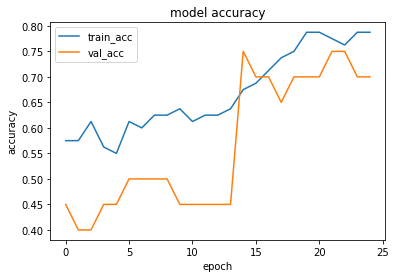

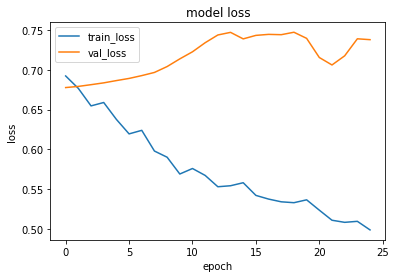

1it [00:00, 17623.13it/s]


prediction for video armflapping_1.mov is [[0.8205383]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.586765]]


1it [00:00, 12192.74it/s]


prediction for video armflapping_2.mov is [[0.6682651]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.02352402]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.911443]]


1it [00:00, 13842.59it/s]


prediction for video control_3.mov is [[0.74640715]]


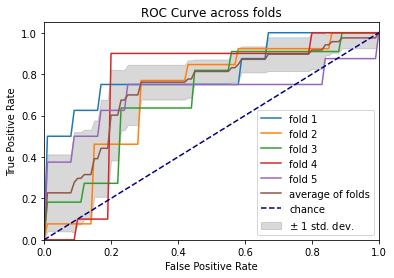

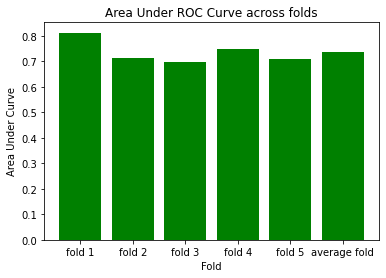

In [61]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 262ms/step - loss: 0.7047 - accuracy: 0.4000 - precision_123: 0.3846 - recall_123: 0.2381 - val_loss: 0.6844 - val_accuracy: 0.4500 - val_precision_123: 0.4000 - val_recall_123: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6834 - accuracy: 0.4875 - precision_123: 0.5088 - recall_123: 0.6905 - val_loss: 0.6756 - val_accuracy: 0.5000 - val_precision_123: 0.4444 - val_recall_123: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6685 - accuracy: 0.6000 - precision_123: 0.5735 - recall_123: 0.9286 - val_loss: 0.6645 - val_accuracy: 0.5000 - val_precision_123: 0.4444 - val_recall_123: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 243ms/step - loss: 0.6653 - accuracy: 0.5625 - precision_123: 0.5479 - recall_123: 0.9524 - val_loss: 0.6571 - val_accuracy: 0.5000 - val_precision_123: 0.4444 - val_recall_123: 1.0000
Epoch 5/75
3/3 [==============================] 

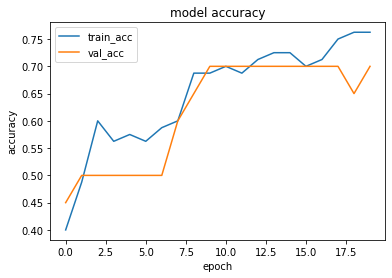

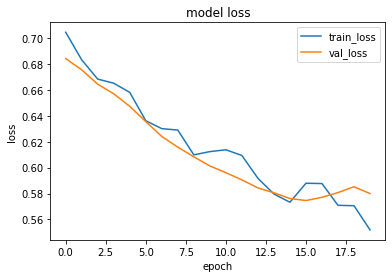

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.43583146]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.5649973]]


1it [00:00, 12192.74it/s]


prediction for video armflapping_2.mov is [[0.3723041]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.2287625]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.74505025]]


1it [00:00, 12483.05it/s]


prediction for video control_3.mov is [[0.29086885]]
Epoch 1/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6947 - accuracy: 0.4750 - precision_124: 0.3684 - recall_124: 0.1892 - val_loss: 0.6788 - val_accuracy: 0.5500 - val_precision_124: 0.6250 - val_recall_124: 0.7692
Epoch 2/75
3/3 [==============================] - 0s 174ms/step - loss: 0.6856 - accuracy: 0.5000 - precision_124: 0.4737 - recall_124: 0.7297 - val_loss: 0.6616 - val_accuracy: 0.6500 - val_precision_124: 0.7500 - val_recall_124: 0.6923
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6749 - accuracy: 0.5875 - precision_124: 0.5435 - recall_124: 0.6757 - val_loss: 0.6458 - val_accuracy: 0.7500 - val_precision_124: 0.7857 - val_recall_124: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6575 - accuracy: 0.6875 - precision_124: 0.6304 - recall_124: 0.7838 - val_loss: 0.6350 - val_accuracy: 0.7500 - val_precision_124: 0.7857 - val_recall_124: 0.

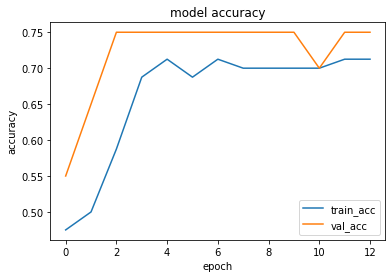

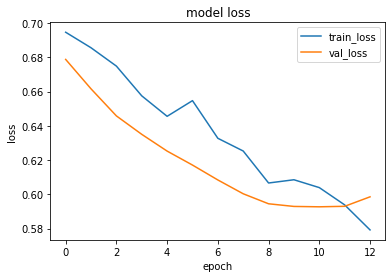

1it [00:00, 8473.34it/s]


prediction for video armflapping_1.mov is [[0.50110716]]


1it [00:00, 11335.96it/s]


prediction for video armflapping_3.mov is [[0.5069892]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_2.mov is [[0.45319614]]


1it [00:00, 13486.51it/s]


prediction for video control_1.mov is [[0.32500324]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.58997357]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.38637996]]
Epoch 1/75
3/3 [==============================] - 1s 397ms/step - loss: 0.6978 - accuracy: 0.5000 - precision_125: 0.4839 - recall_125: 0.3846 - val_loss: 0.6775 - val_accuracy: 0.6500 - val_precision_125: 0.6667 - val_recall_125: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6714 - accuracy: 0.5250 - precision_125: 0.5106 - recall_125: 0.6154 - val_loss: 0.6632 - val_accuracy: 0.6000 - val_precision_125: 0.6000 - val_recall_125: 0.8182
Epoch 3/75
3/3 [==============================] - 1s 195ms/step - loss: 0.6534 - accuracy: 0.5250 - precision_125: 0.5072 - recall_125: 0.8974 - val_loss: 0.6538 - val_accuracy: 0.6000 - val_precision_125: 0.5789 - val_recall_125: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 180ms/step - loss: 0.6534 - accuracy: 0.5625 - precision_125: 0.5278 - recall_125: 0.9744 - val_loss: 0.6462 - val_accuracy: 0.6500 - val_precision_125: 0.6111 - val_recall_125: 1.

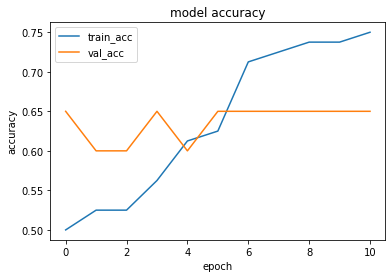

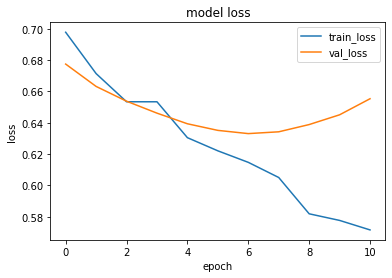

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.24134961]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.5927257]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_2.mov is [[0.19060445]]


1it [00:00, 13842.59it/s]


prediction for video control_1.mov is [[0.10172185]]


1it [00:00, 12157.40it/s]


prediction for video control_2.mov is [[0.8312125]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.14233267]]
Epoch 1/75
3/3 [==============================] - 1s 298ms/step - loss: 0.7153 - accuracy: 0.3500 - precision_126: 0.3421 - recall_126: 0.3250 - val_loss: 0.6884 - val_accuracy: 0.6000 - val_precision_126: 0.5714 - val_recall_126: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6968 - accuracy: 0.4500 - precision_126: 0.4688 - recall_126: 0.7500 - val_loss: 0.6642 - val_accuracy: 0.6000 - val_precision_126: 0.5556 - val_recall_126: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 194ms/step - loss: 0.6759 - accuracy: 0.5500 - precision_126: 0.5270 - recall_126: 0.9750 - val_loss: 0.6464 - val_accuracy: 0.6000 - val_precision_126: 0.5556 - val_recall_126: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 167ms/step - loss: 0.6697 - accuracy: 0.5375 - precision_126: 0.5205 - recall_126: 0.9500 - val_loss: 0.6329 - val_accuracy: 0.6000 - val_precision_126: 0.5556 - val_recall_126: 1.

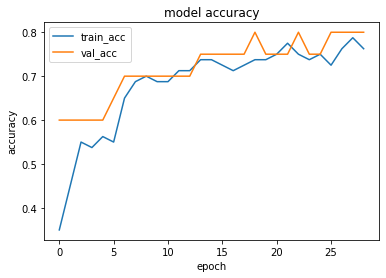

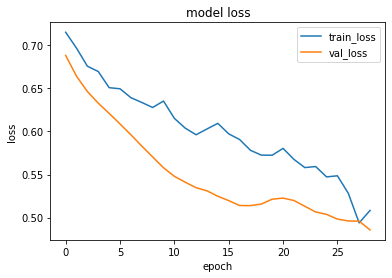

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.29891875]]


1it [00:00, 11008.67it/s]


prediction for video armflapping_3.mov is [[0.5875344]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.23368171]]


1it [00:00, 10979.85it/s]


prediction for video control_1.mov is [[0.11389944]]


1it [00:00, 9986.44it/s]


prediction for video control_2.mov is [[0.7984859]]


1it [00:00, 13189.64it/s]


prediction for video control_3.mov is [[0.18481082]]
Epoch 1/75
3/3 [==============================] - 1s 286ms/step - loss: 0.6890 - accuracy: 0.4750 - precision_127: 0.5000 - recall_127: 0.6667 - val_loss: 0.6942 - val_accuracy: 0.3500 - val_precision_127: 0.3684 - val_recall_127: 0.8750
Epoch 2/75
3/3 [==============================] - 1s 188ms/step - loss: 0.6717 - accuracy: 0.5000 - precision_127: 0.5156 - recall_127: 0.7857 - val_loss: 0.6955 - val_accuracy: 0.3500 - val_precision_127: 0.3684 - val_recall_127: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6509 - accuracy: 0.5750 - precision_127: 0.5556 - recall_127: 0.9524 - val_loss: 0.6991 - val_accuracy: 0.3500 - val_precision_127: 0.3684 - val_recall_127: 0.8750
Epoch 4/75
3/3 [==============================] - 1s 195ms/step - loss: 0.6409 - accuracy: 0.6000 - precision_127: 0.5676 - recall_127: 1.0000 - val_loss: 0.7029 - val_accuracy: 0.3500 - val_precision_127: 0.3684 - val_recall_127: 0.

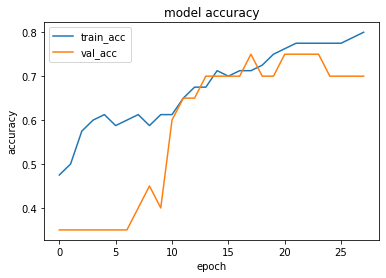

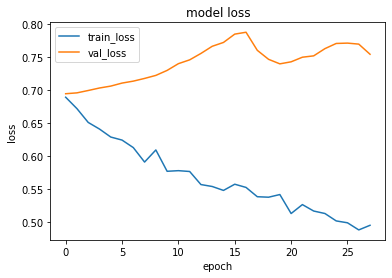

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.91454685]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.58983445]]


1it [00:00, 12372.58it/s]


prediction for video armflapping_2.mov is [[0.87280667]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.03841415]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.8763982]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.87311137]]


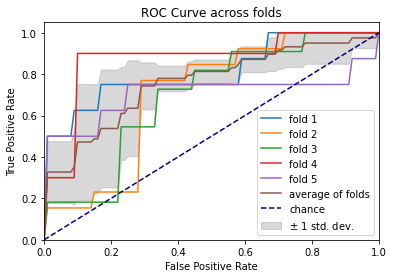

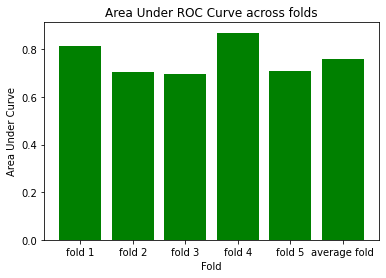

In [62]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [65]:
np.mean(AVERAGE_AUROCS[-10:]), np.std(AVERAGE_AUROCS[-10:])

(0.7520182539682541, 0.014955176988806856)

In [68]:
x = [1, 2, 3] 
x[-2:]

[2, 3]